# 

In [123]:
## Path
import pandas as pd
import os
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from pingouin import anova
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as ols
print(os.getcwd())

C:\Users\zachw\PycharmProjects\cancer_analysis


In [124]:
## Read in cancer dataset
cancer_df = pd.read_csv("cancer_reg.csv")

print(cancer_df["medianage"].describe())

cancer_df.shape
cancer_df.columns

count    3047.000000
mean       45.272333
std        45.304480
min        22.300000
25%        37.700000
50%        41.000000
75%        44.000000
max       624.000000
Name: medianage, dtype: float64


Index(['avganncount', 'avgdeathsperyear', 'target_deathrate', 'incidencerate',
       'medincome', 'popest2015', 'povertypercent', 'studypercap', 'binnedinc',
       'medianage', 'medianagemale', 'medianagefemale', 'geography',
       'percentmarried', 'pctnohs18_24', 'pcths18_24', 'pctsomecol18_24',
       'pctbachdeg18_24', 'pcths25_over', 'pctbachdeg25_over',
       'pctemployed16_over', 'pctunemployed16_over', 'pctprivatecoverage',
       'pctprivatecoveragealone', 'pctempprivcoverage', 'pctpubliccoverage',
       'pctpubliccoveragealone', 'pctwhite', 'pctblack', 'pctasian',
       'pctotherrace', 'pctmarriedhouseholds', 'birthrate'],
      dtype='object')

In [125]:
#cancer_df.head()
#cancer_df["medianage"].sample(20)
## Error! Some entries are incorrect for medianage
# View the distribution of medianage

# Identifying counties with median age over 100 (not possible, error in data entry, etc)
suspicious_entries = cancer_df[cancer_df["medianage"] > 100]
print(suspicious_entries["medianage"])
print(suspicious_entries.shape)

# Calculate the median of valid entries (counties with median age under 100)
valid_median = cancer_df[cancer_df["medianage"] <= 100]["medianage"].median()

# Replace invalid values with the median
cancer_df["medianage"] = cancer_df["medianage"].apply(lambda x: valid_median if x > 100 else x)


print(cancer_df["medianage"].describe())



100     458.4
181     469.2
225     546.0
318     624.0
425     508.8
606     619.2
637     498.0
843     412.8
991     481.2
1199    424.8
1312    535.2
1406    406.8
1579    579.6
1725    502.8
1736    496.8
1744    525.6
1767    519.6
1855    536.4
2000    523.2
2108    470.4
2132    430.8
2391    414.0
2422    500.4
2431    429.6
2589    501.6
2668    496.8
2789    349.2
2835    511.2
2895    498.0
2966    508.8
Name: medianage, dtype: float64
(30, 33)
count    3047.000000
mean       40.824614
std         5.171283
min        22.300000
25%        37.700000
50%        40.900000
75%        43.800000
max        65.300000
Name: medianage, dtype: float64


In [126]:
## Check the # of missing values in each column
## Keep in mind there are 3047 total rows in the cancer_df dataframe
cancer_df.columns = cancer_df.columns.str.strip()
missing_values_cancer = cancer_df.isnull().sum()
print(missing_values_cancer)

avganncount                   0
avgdeathsperyear              0
target_deathrate              0
incidencerate                 0
medincome                     0
popest2015                    0
povertypercent                0
studypercap                   0
binnedinc                     0
medianage                     0
medianagemale                 0
medianagefemale               0
geography                     0
percentmarried                0
pctnohs18_24                  0
pcths18_24                    0
pctsomecol18_24            2285
pctbachdeg18_24               0
pcths25_over                  0
pctbachdeg25_over             0
pctemployed16_over          152
pctunemployed16_over          0
pctprivatecoverage            0
pctprivatecoveragealone     609
pctempprivcoverage            0
pctpubliccoverage             0
pctpubliccoveragealone        0
pctwhite                      0
pctblack                      0
pctasian                      0
pctotherrace                  0
pctmarri

In [127]:
## We need to deal with missing values in our dataframe. 
## First, lets delete the column "pctsomecol18_24" because over 66% of rows are missing an entry for this variable. 
cancer_df.drop(columns=["pctsomecol18_24"], inplace=True)

In [128]:
## First, we need to find a way to deal with the 609 missing values in the pctprivatecoveragealone column. 
## Why do these specific counties have missing values for this variable? Perhaps some counties/states require its citizens to have public health insurance
## From google - US States California, Massachusetts, Rhode Island, New Jersey, and Vermont REQUIRE public health insurance with an option for private 
## Let's check this...

## Subset df of counties with missing value for pctprivatecoveragealone
cancer_df_missing_private_alone = cancer_df[cancer_df["pctprivatecoveragealone"].isnull()]
cancer_df_missing_private_alone["geography"].unique()
#cancer_df_missing_private_alone.shape
## There are counties in SEVERAL states that have missing values for this column. 

## Make a dataframe where rows are NOT missing a value for pctprivatecoveragealon
cancer_df_contains_private_alone = cancer_df[~(cancer_df["pctprivatecoveragealone"].isnull())]
cancer_df_contains_private_alone.shape
cancer_df_contains_private_alone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2438 entries, 1 to 3046
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avganncount              2438 non-null   float64
 1   avgdeathsperyear         2438 non-null   int64  
 2   target_deathrate         2438 non-null   float64
 3   incidencerate            2438 non-null   float64
 4   medincome                2438 non-null   int64  
 5   popest2015               2438 non-null   int64  
 6   povertypercent           2438 non-null   float64
 7   studypercap              2438 non-null   float64
 8   binnedinc                2438 non-null   object 
 9   medianage                2438 non-null   float64
 10  medianagemale            2438 non-null   float64
 11  medianagefemale          2438 non-null   float64
 12  geography                2438 non-null   object 
 13  percentmarried           2438 non-null   float64
 14  pctnohs18_24             2438

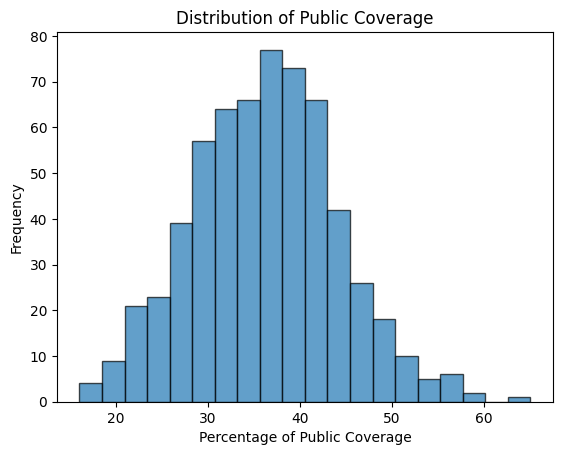

In [129]:
## Maybe the columns with missing values for private coverage alone require public health insurance? Let's check this...
cancer_df_missing_private_alone[["geography", "pctpubliccoverage", "pctprivatecoverage", "pctpubliccoveragealone", "pctempprivcoverage", "pctprivatecoveragealone"]]
## Why do these counties in particluar have missing values for private coverage alone?

# Distribution of pctpubliccoverage among counties missing values for pctprivatecoveragealone.
plt.hist(cancer_df_missing_private_alone["pctpubliccoverage"], bins=20, edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Percentage of Public Coverage')
plt.ylabel('Frequency')
plt.title('Distribution of Public Coverage')

# Show the plot
plt.show()

In [130]:
## Let's compare income statistics for the dataset with missing values (private only variable) compared to the dataset without missing values
## Note that we dont have effect size differences, but

income_dict = {
    "medians income comparison (missing, contains)":
[cancer_df_missing_private_alone["medincome"].median(),
cancer_df_contains_private_alone["medincome"].median()], 
    "means income comparison (missing, contains)":
## medians seem to be similiar

[cancer_df_missing_private_alone["medincome"].mean(),
cancer_df_contains_private_alone["medincome"].mean()],
## means also seem to be similiar
    "poverty percent comparison (missing, contains)":
    [cancer_df_missing_private_alone["povertypercent"].median(), 
     cancer_df_contains_private_alone["povertypercent"].median()]
## poverty percent also seems to be similiar for the dataset missing private only and the dataset containing private only
}
print(income_dict)

## Don't know the variance of each median/mean for these variables, but the differences don't seem to be statistically significant

{'medians income comparison (missing, contains)': [np.float64(45363.0), np.float64(45194.0)], 'means income comparison (missing, contains)': [np.float64(47189.49261083744), np.float64(47031.7551271534)], 'poverty percent comparison (missing, contains)': [np.float64(15.8), np.float64(15.9)]}


In [131]:
## Let's compare public coverage % among the data with missing private only coverage and the data without missing private only %

public_option = {
    "public only (missing private data, contains private data)":
    [cancer_df_missing_private_alone["pctpubliccoveragealone"].median(),
cancer_df_contains_private_alone["pctpubliccoveragealone"].median()], 
    "public (missing private data, contains private data)":
    [cancer_df_missing_private_alone["pctpubliccoverage"].median(),
cancer_df_contains_private_alone["pctpubliccoverage"].median()]
}
print(public_option)

{'public only (missing private data, contains private data)': [np.float64(18.8), np.float64(18.8)], 'public (missing private data, contains private data)': [np.float64(36.3), np.float64(36.4)]}


In [132]:
population_comparison = {
    "population (missing, contains)" :
    [cancer_df_missing_private_alone["popest2015"].median(),
cancer_df_contains_private_alone["popest2015"].median()]
}
print(population_comparison)

## Is this difference statistically significant? 
from scipy.stats import ttest_ind
## check assumptions

# Test for significant difference in population
t_stat, p_value = ttest_ind(
    cancer_df_missing_private_alone["popest2015"].dropna(),
    cancer_df_contains_private_alone["popest2015"].dropna()
)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

## Not a significant difference in population between datasets

{'population (missing, contains)': [np.float64(25594.0), np.float64(26946.5)]}
T-statistic: -0.071924883496711, P-value: 0.942666410747504


In [133]:
## Now we need to deal wit "pctemployed16_over". Maybe it's just 1 - pctunemployed16_over? 
#cancer_df[["pctemployed16_over", "pctunemployed16_over"]]

## Let's just fill this in with the median for now and assume the data is missing in a random pattern. 
## This variable isn't used in any analysis later on so this is a fine decision
## Might need to build a quick linear regression model to fill in missing values for pctemployed16_over
cancer_df['pctemployed16_over'].fillna(cancer_df['pctemployed16_over'].median(), inplace=True)
cancer_df[["pctemployed16_over", "pctunemployed16_over"]]

C:\Users\zachw\AppData\Local\Temp\ipykernel_12672\2523380235.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cancer_df['pctemployed16_over'].fillna(cancer_df['pctemployed16_over'].median(), inplace=True)


pctemployed16_over  pctunemployed16_over
0                   51.9                   8.0
1                   55.9                   7.8
2                   45.9                   7.0
3                   48.3                  12.1
4                   48.2                   4.8
...                  ...                   ...
3042                51.7                   4.3
3043                70.1                   4.6
3044                64.8                   6.4
3045                54.5                   6.9
3046                48.8                   9.2

[3047 rows x 2 columns]

In [134]:
missing_values_cancer_two = cancer_df.isnull().sum()
print(missing_values_cancer_two)
## Now the only variable with any missing values is pctprivatecoveratealone

avganncount                  0
avgdeathsperyear             0
target_deathrate             0
incidencerate                0
medincome                    0
popest2015                   0
povertypercent               0
studypercap                  0
binnedinc                    0
medianage                    0
medianagemale                0
medianagefemale              0
geography                    0
percentmarried               0
pctnohs18_24                 0
pcths18_24                   0
pctbachdeg18_24              0
pcths25_over                 0
pctbachdeg25_over            0
pctemployed16_over           0
pctunemployed16_over         0
pctprivatecoverage           0
pctprivatecoveragealone    609
pctempprivcoverage           0
pctpubliccoverage            0
pctpubliccoveragealone       0
pctwhite                     0
pctblack                     0
pctasian                     0
pctotherrace                 0
pctmarriedhouseholds         0
birthrate                    0
dtype: i

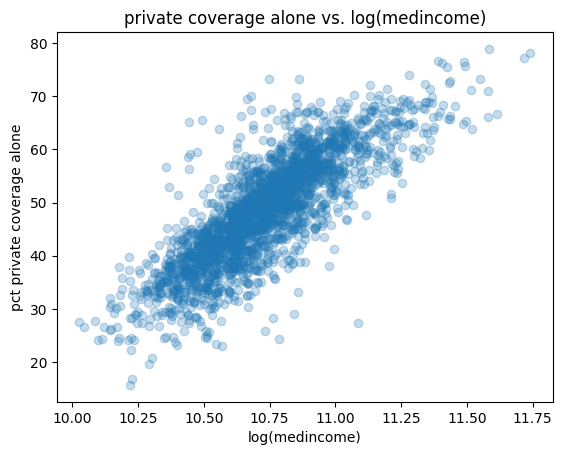

Correlation coefficient between log(medincome) and pct private coverage alone: 0.82


In [135]:
## Steps to address the 609 missing values for pctprivatecoveragealone:
## Use medianincome to predict pctprivatecoveragealone missing values and impute using Linear Regression

## Note that medianincome and pctprivatecoveragealone have an exponential distribution (see scatterplot below).

## So make a new variable log(medianincome) and check if it has a linear relationship with pctprivatecoveragealone
## Check relationship assumptions, then, build the model and use it's predictions to impute missing values.

## This is a natural log (ln) transformation (base e)
cancer_df["log_medincome"] = np.log(cancer_df['medincome']) 
cancer_df.head()


plt.scatter(cancer_df["log_medincome"], cancer_df["pctprivatecoveragealone"], alpha=0.25)
plt.title("private coverage alone vs. log(medincome)")
plt.xlabel("log(medincome)")
plt.ylabel("pct private coverage alone")
plt.show()

# Calculate the correlation coefficient
correlation = cancer_df['log_medincome'].corr(cancer_df['pctprivatecoveragealone'])
print(f"Correlation coefficient between log(medincome) and pct private coverage alone: {round(correlation, 2)}")


In [136]:
## Now, make a LR model predicting the missing values for pct private coverage alone using log(medincome)

## We will build our LR model using the dataframe cancer_df_contains_private_alone
## First add the variable log(medincome) to cancer_df_contains_private_alone

#print(cancer_df["pctprivatecoveragealone"].isna().sum())  # Number of missing values

## create a copy. 
cancer_df_contains_private_alone = cancer_df_contains_private_alone.copy()
print(cancer_df["pctprivatecoveragealone"].isna().sum())

## add log_medincome column to contains
cancer_df_contains_private_alone["log_medincome"] = np.log(cancer_df_contains_private_alone["medincome"])
print(cancer_df["pctprivatecoveragealone"].isna().sum())
#cancer_df_contains_private_alone.columns

## Create a copy. 
cancer_df_missing_private_alone = cancer_df_missing_private_alone.copy()
print(cancer_df["pctprivatecoveragealone"].isna().sum())

##add log_medincome column to missing
cancer_df_missing_private_alone["log_medincome"] = np.log(cancer_df_missing_private_alone["medincome"])
print(cancer_df["pctprivatecoveragealone"].isna().sum())


# 3. Split the data into rows with and without missing values
x_train = cancer_df_contains_private_alone[["log_medincome"]]
y_train = cancer_df_contains_private_alone["pctprivatecoveragealone"]

model = LinearRegression()
model.fit(x_train, y_train)

x_missing = cancer_df_missing_private_alone[["log_medincome"]]
predicted_private_cov_alone = model.predict(x_missing)


#print(cancer_df["pctprivatecoveragealone"].isna().sum())

#predicted_private_cov_alone.shape
#cancer_df["pctprivatecoveragealone"]

## Replace missing values in the original DataFrame
#cancer_df.loc[cancer_df["pctprivatecoveragealone"].isna(), "pctprivatecoveragealone"] = predicted_private_cov_alone

cancer_df["pctprivatecoveragealone"] = cancer_df["pctprivatecoveragealone"].fillna(
    pd.Series(predicted_private_cov_alone, index=cancer_df_missing_private_alone.index)
)

cancer_df.head()
print(cancer_df["pctprivatecoveragealone"].isna().sum())  # Number of missing values

## 609 values 
predicted_private_cov_alone

# Extract the rows where the values were previously missing
missing_indices = cancer_df_missing_private_alone.index

# Check the replaced values
print(cancer_df.loc[missing_indices, "pctprivatecoveragealone"])  # Should match predicted_private_cov_alone
print(predicted_private_cov_alone)  # Compare the two outputs


## Worked!

609
609
609
609
0
0       59.005930
9       58.154059
10      54.729285
11      52.553260
23      55.984757
          ...    
3007    46.003544
3015    48.432976
3025    57.996271
3026    49.469617
3036    49.813266
Name: pctprivatecoveragealone, Length: 609, dtype: float64
[59.00593043 58.15405875 54.72928538 52.55325963 55.98475738 36.86765609
 44.72022666 46.94791978 39.26670449 47.51228942 40.55830905 44.02364858
 40.64501444 45.49175998 47.47244778 45.39064926 59.02778798 51.4013736
 53.83446718 44.15806785 47.73021656 49.33282824 53.52989834 57.8273247
 67.75740834 75.82858229 42.27615895 78.47531323 45.32917596 32.77786787
 55.61891988 32.73845112 36.41912848 47.0770299  45.34663215 39.06411861
 48.57410738 47.3251842  41.65506289 48.8448944  59.02666742 41.50221429
 48.27217656 41.84403262 68.41166325 70.58656125 37.85201086 36.91431095
 45.60907641 62.10283742 51.02028338 49.58748668 58.92117237 54.90955092
 49.0083025  46.63624154 43.61199672 43.08825109 48.58395    44.464588

In [137]:
### Now we have no missing values. 
cancer_df.info()
### For the next step of our data cleaning, we need to compute some variables that might be more useful for analysis. 
### For instance, avganncount (#deaths/year) isn't the most useful variable because it doesn't account for population size of that county. 

## Create the variable (avg deaths per year / population estimate) * 100, which represents the avg number of people out of 100 killed by cancer for that 
## county

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3047 entries, 0 to 3046
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avganncount              3047 non-null   float64
 1   avgdeathsperyear         3047 non-null   int64  
 2   target_deathrate         3047 non-null   float64
 3   incidencerate            3047 non-null   float64
 4   medincome                3047 non-null   int64  
 5   popest2015               3047 non-null   int64  
 6   povertypercent           3047 non-null   float64
 7   studypercap              3047 non-null   float64
 8   binnedinc                3047 non-null   object 
 9   medianage                3047 non-null   float64
 10  medianagemale            3047 non-null   float64
 11  medianagefemale          3047 non-null   float64
 12  geography                3047 non-null   object 
 13  percentmarried           3047 non-null   float64
 14  pctnohs18_24            

In [138]:
## Create some new variables that are more useful for analysis

cancer_df["avg_cases_per_100"] = (cancer_df["avganncount"] / cancer_df["popest2015"]) * 100
cancer_df["avg_deaths_per_100"] = (cancer_df["avgdeathsperyear"] / cancer_df["popest2015"]) * 100
cancer_df["case_fatality_rate"] = (cancer_df["avgdeathsperyear"] / cancer_df["avganncount"])
cancer_df['income_group'] = pd.qcut(cancer_df['medincome'], q=3, labels=['Low', 'Middle', 'High'])
cancer_df['public_only_reliance'] = pd.qcut(cancer_df['pctpubliccoveragealone'], q=3, labels=['Low', 'Middle', 'High'])
cancer_df['private_only_reliance'] = pd.qcut(cancer_df['pctprivatecoveragealone'], q=3, labels=['Low', 'Middle', 'High'])
# Create a new column 'state' by splitting the 'geography' column
cancer_df['state'] = cancer_df['geography'].apply(lambda x: x.split(', ')[1])
cancer_df["case_fatality_groups_three"] =  pd.qcut(cancer_df['case_fatality_rate'], q=3, labels=['Low', 'Middle', 'High'])
cancer_df["case_fatality_groups_five"] = pd.qcut(cancer_df['case_fatality_rate'], q=5, labels=['Low', "Low Middle", 'Middle', "Middle High", 'High'])

# Display the first few rows to confirm
print(cancer_df[['geography', 'state']].sample(20))
## High case fatality rates might indicate disparities in access to healthcare, quality of treatment, or late-stage cancer diagnoses in certain counties.
cancer_df.sample(10)


                            geography         state
2242       Vermillion County, Indiana       Indiana
1977             Upshur County, Texas         Texas
146         Hudson County, New Jersey    New Jersey
1675            Van Wert County, Ohio          Ohio
113            Douglas County, Nevada        Nevada
2850         Fayette County, Illinois      Illinois
2801  Hutchinson County, South Dakota  South Dakota
2374        Crawford County, Illinois      Illinois
542        Lafayette County, Arkansas      Arkansas
2628             Cobb County, Georgia       Georgia
2910           Scott County, Illinois      Illinois
1122     Green Lake County, Wisconsin     Wisconsin
1110          Antrim County, Michigan      Michigan
1210       Kemper County, Mississippi   Mississippi
2935             Cass County, Indiana       Indiana
797       Bienville Parish, Louisiana     Louisiana
2911          Shelby County, Illinois      Illinois
1906            Lubbock County, Texas         Texas
1141        

avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
2469  1962.667684                40             158.9     453.549422   
719    143.000000                61             213.5     509.600000   
105     30.000000                14             215.0     453.600000   
2965    57.000000                19             159.8     548.400000   
1206   102.000000                42             194.1     468.100000   
1648   219.000000                95             181.9     443.100000   
2959    78.000000                30             171.3     492.100000   
1245   106.000000                45             175.7     415.100000   
1769   753.000000               330             164.3     384.500000   
1416   125.000000                53             212.4     494.600000   

      medincome  popest2015  povertypercent  studypercap           binnedinc  \
2469      48163       14050            13.5  1138.790036  (48021.6, 51046.4]   
719       37443       24363            20.2     0.000000  (37413.8, 40362.7]   
105       41344        7064            34.0     0.000000  (40362.7, 42724.4]   
2965      53905        7028            10.9     0.000000  (51046.4, 54545.6]   
1206      35019       16569            22.7     0.000000  (34218.1, 37413.8]   
1648      52606       40968             8.9     0.000000  (51046.4, 54545.6]   
2959      57682       10974             8.4     0.000000  (54545.6, 61494.5]   
1245      37026       22131            19.1     0.000000  (34218.1, 37413.8]   
1769      48537      165829            16.6     6.030308  (48021.6, 51046.4]   
1416      39546       22583            18.1   929.903024  (37413.8, 40362.7]   

      medianage  ...  log_medincome  avg_cases_per_100 avg_deaths_per_100  \
2469       46.7  ...      10.782346          13.969165           0.284698   
719        40.7  ...      10.530575           0.586956           0.250380   
105        28.6  ...      10.629683           0.424689           0.198188   
2965       45.1  ...      10.894979           0.811042           0.270347   
1206       41.6  ...      10.463646           0.615607           0.253485   
1648       40.1  ...      10.870585           0.534564           0.231888   
2959       44.0  ...      10.962700           0.710771           0.273373   
1245       38.4  ...      10.519376           0.478966           0.203335   
1769       40.9  ...      10.790082           0.454082           0.199000   
1416       38.9  ...      10.585220           0.553514           0.234690   

      case_fatality_rate  income_group  public_only_reliance  \
2469            0.020380        Middle                Middle   
719             0.426573           Low                  High   
105             0.466667        Middle                  High   
2965            0.333333          High                   Low   
1206            0.411765           Low                  High   
1648            0.433790          High                   Low   
2959            0.384615          High                   Low   
1245            0.424528           Low                  High   
1769            0.438247        Middle                Middle   
1416            0.424000           Low                  High   

      private_only_reliance           state  case_fatality_groups_three  \
2469                 Middle       Minnesota                         Low   
719                     Low       Tennessee                      Middle   
105                     Low        Nebraska                        High   
2965                   High            Iowa                         Low   
1206                    Low     Mississippi                      Middle   
1648                   High            Ohio                        High   
2959                   High            Iowa                      Middle   
1245                    Low     Mississippi                      Middle   
1769                 Middle  South Carolina                        High   
1416                    Low  

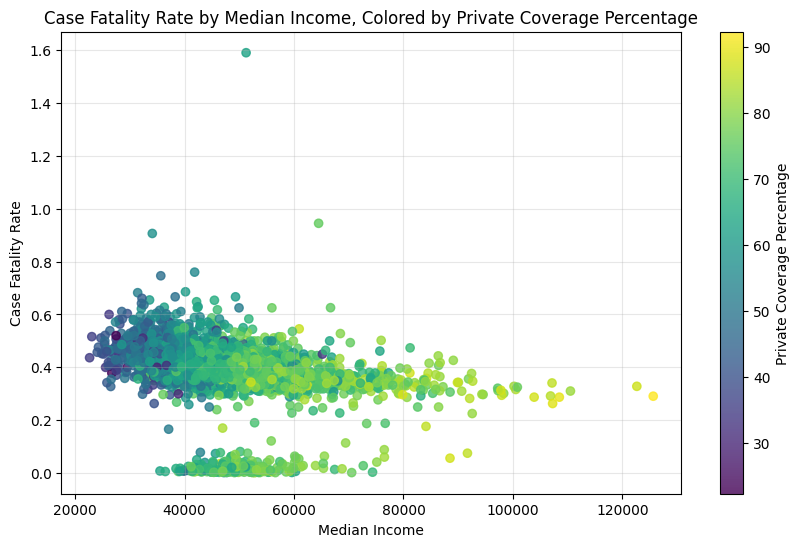

In [139]:
# Scatterplot of case fatality rate by median income colored by private coverage percentage
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cancer_df['medincome'], cancer_df['case_fatality_rate'], 
                       c=cancer_df['pctprivatecoverage'], cmap='viridis', alpha=0.8)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Private Coverage Percentage')

# Add labels and title
plt.xlabel('Median Income')
plt.ylabel('Case Fatality Rate')
plt.title('Case Fatality Rate by Median Income, Colored by Private Coverage Percentage')
plt.grid(alpha=0.3)

# Show the plot
plt.show()

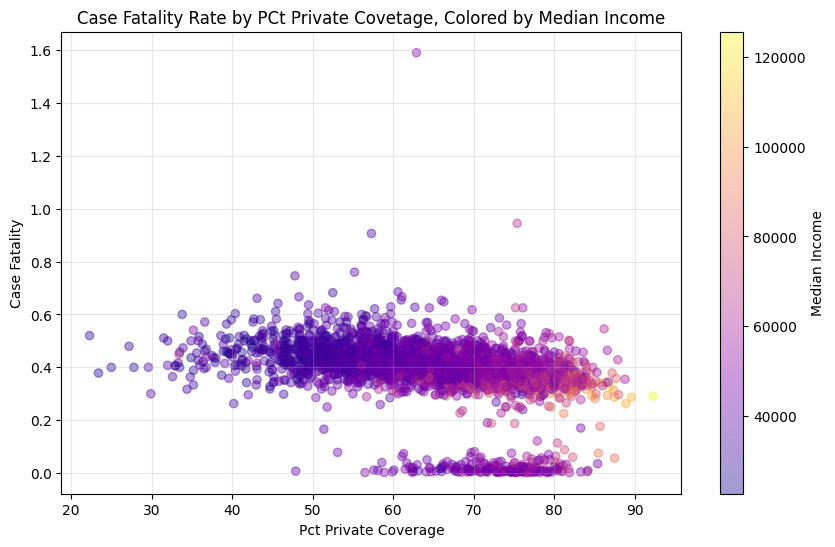

In [140]:
# Create the scatterplot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cancer_df['pctprivatecoverage'], cancer_df['case_fatality_rate'], 
                       c=cancer_df['medincome'], cmap='plasma', alpha=0.4)

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Median Income')

# Add labels and title
plt.xlabel("Pct Private Coverage")
plt.ylabel('Case Fatality')
plt.title('Case Fatality Rate by PCt Private Covetage, Colored by Median Income')
plt.grid(alpha=0.3)

# Show the plot
plt.show()

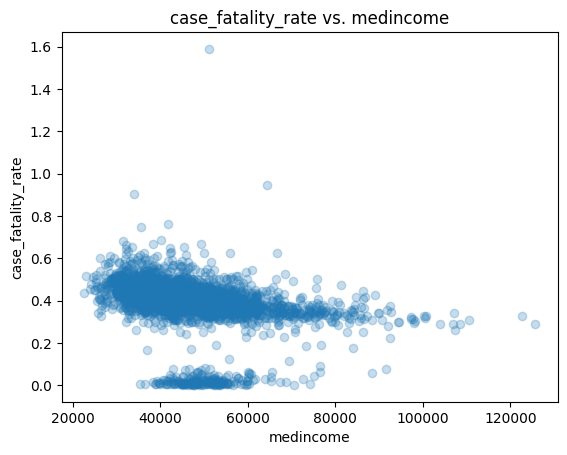

In [141]:
### First, let's just make some exploratory scatterplots to get a sense of the trends in the data
## Maybe put this in a function to make it more repeatable?...
## syntax is plt.scatter(df["x"], df["y"])

def make_scatter(x_var, y_var):
    plt.scatter(cancer_df[x_var], cancer_df[y_var], alpha=0.25)
    plt.title(y_var + " vs. " + x_var)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()

make_scatter("medincome", "case_fatality_rate")

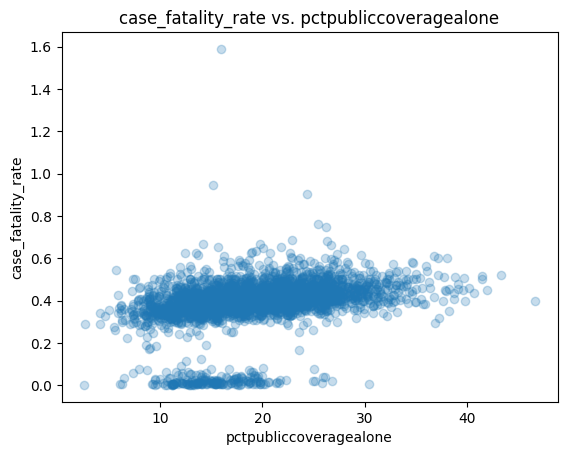

In [142]:
## Scatterplot of case fatality rate vs. pct public coverage alone
make_scatter("pctpubliccoveragealone", "case_fatality_rate")

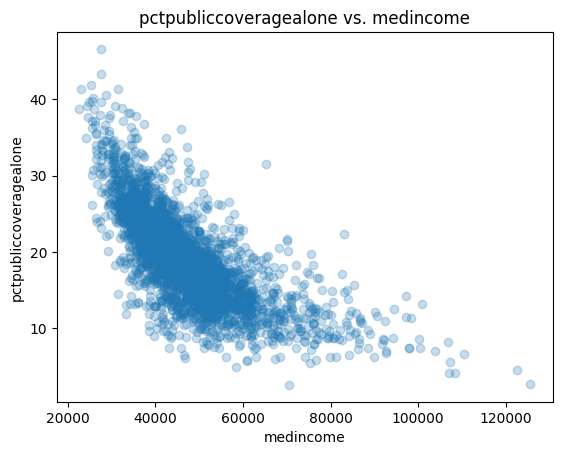

In [143]:
make_scatter("medincome", "pctpubliccoveragealone")

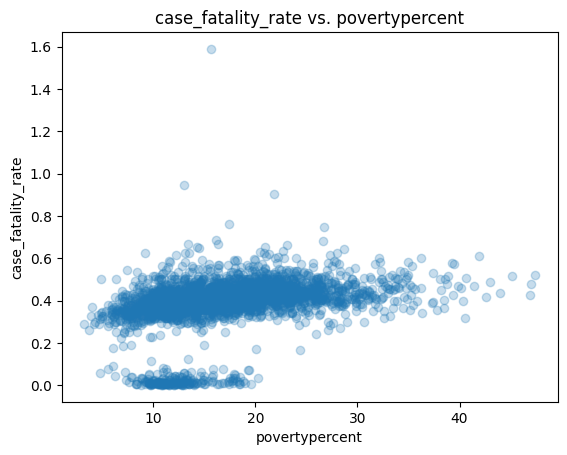

In [144]:
make_scatter("povertypercent", "case_fatality_rate")

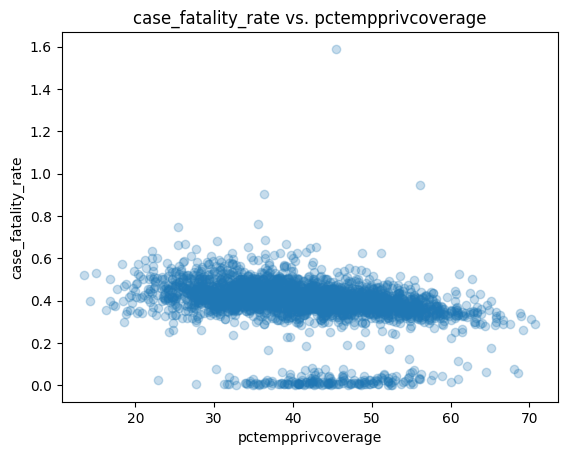

In [145]:
make_scatter("pctempprivcoverage", "case_fatality_rate")

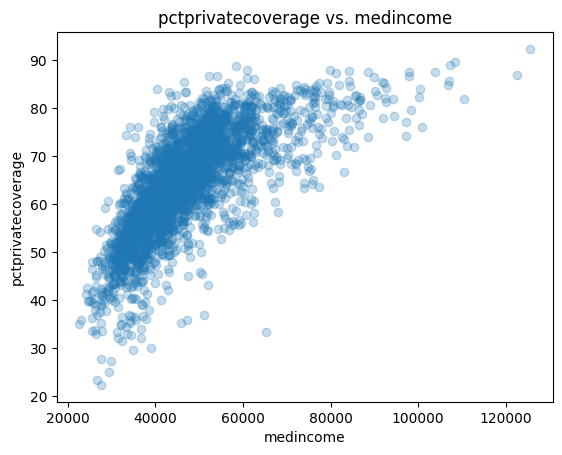

In [146]:
make_scatter("medincome", "pctprivatecoverage")

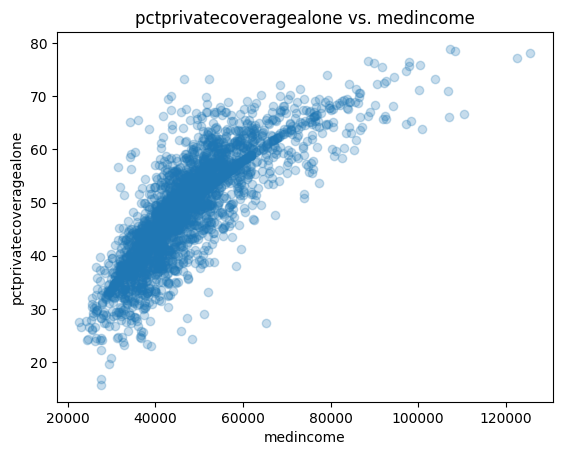

In [147]:
make_scatter("medincome", "pctprivatecoveragealone")

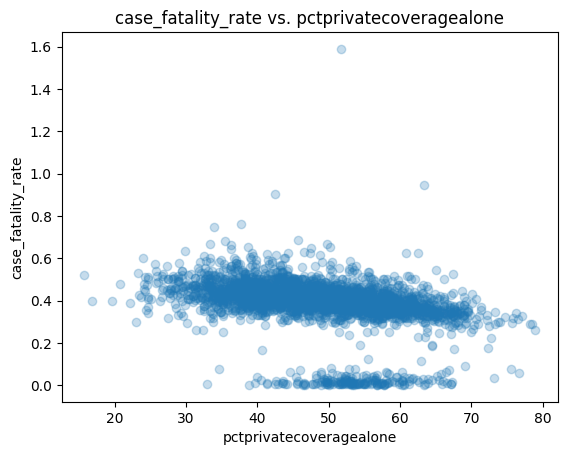

In [148]:
make_scatter("pctprivatecoveragealone", "case_fatality_rate")

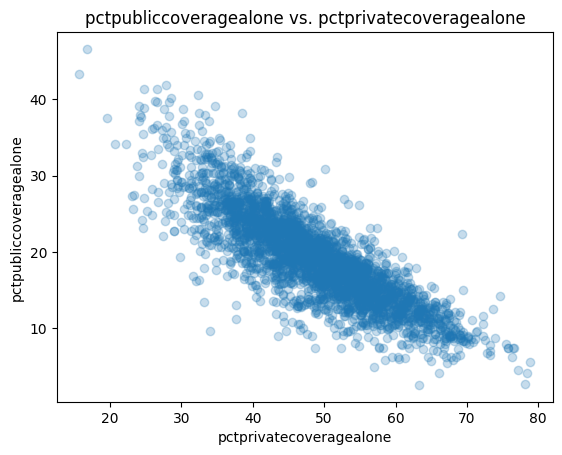

In [149]:
make_scatter("pctprivatecoveragealone", "pctpubliccoveragealone")

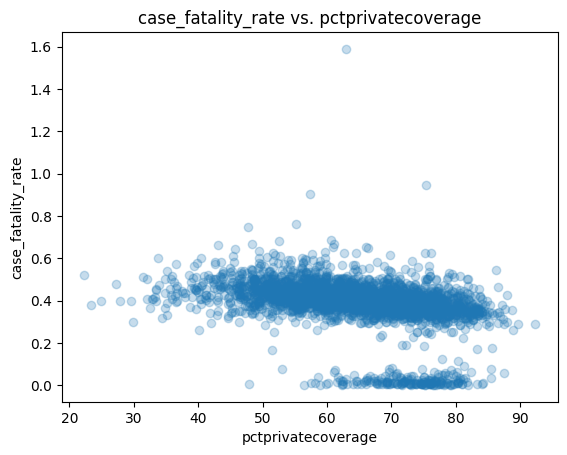

In [150]:
make_scatter("pctprivatecoverage", "case_fatality_rate")

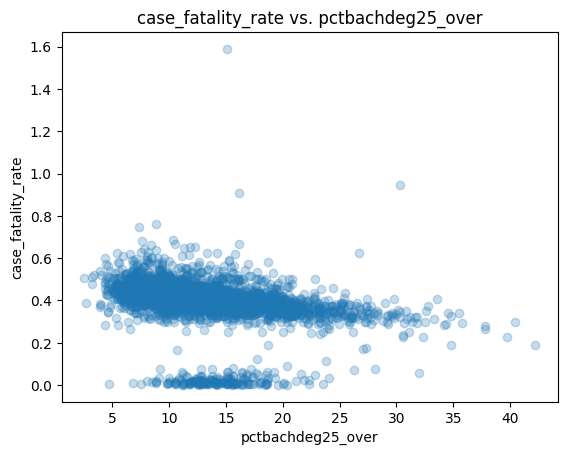

In [151]:
make_scatter("pctbachdeg25_over", "case_fatality_rate")

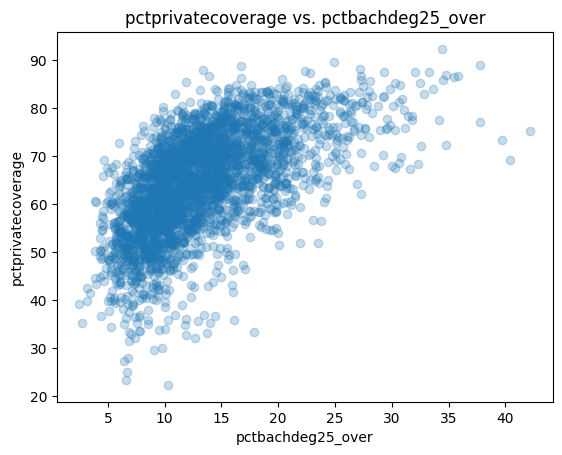

In [152]:
make_scatter("pctbachdeg25_over", "pctprivatecoverage")

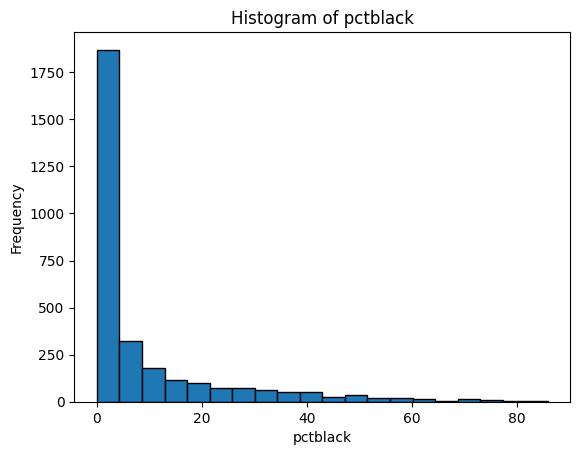

In [153]:
## Histogram function to make a histogram of any quantitative variable. Allows us to quickly see the distribution of a quantitative variable. 
# Creating a histogram for the 'pctblack' column

def create_hist(var):
    plt.hist(cancer_df[var], bins=20, edgecolor='black')
    plt.title("Histogram of " + var)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.show()

create_hist("pctblack")

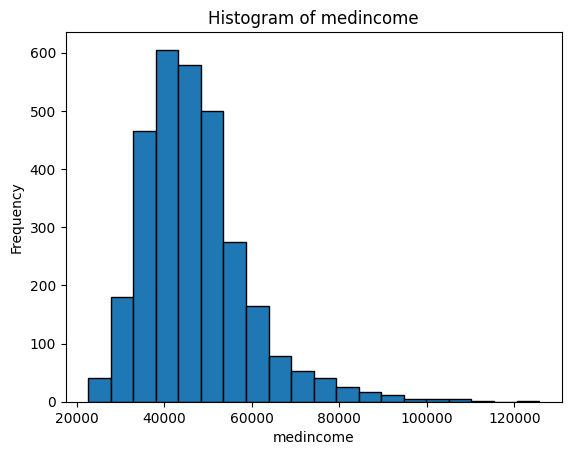

In [154]:
create_hist("medincome")

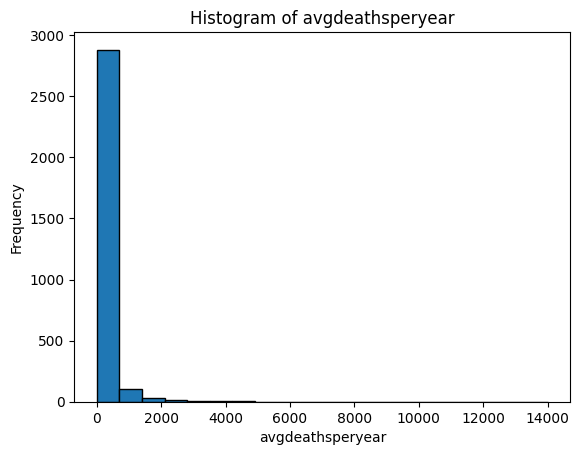

In [155]:
create_hist("avgdeathsperyear")

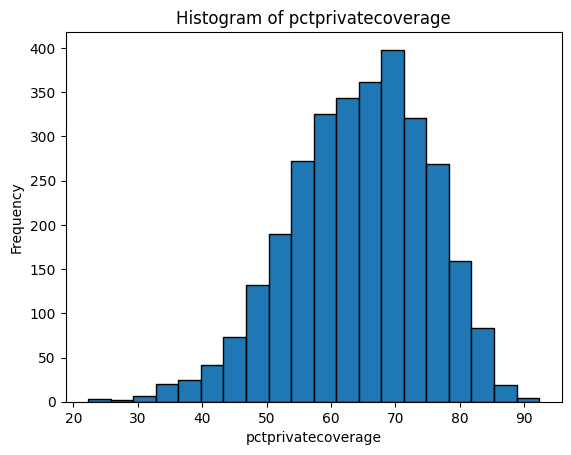

In [156]:
create_hist("pctprivatecoverage")

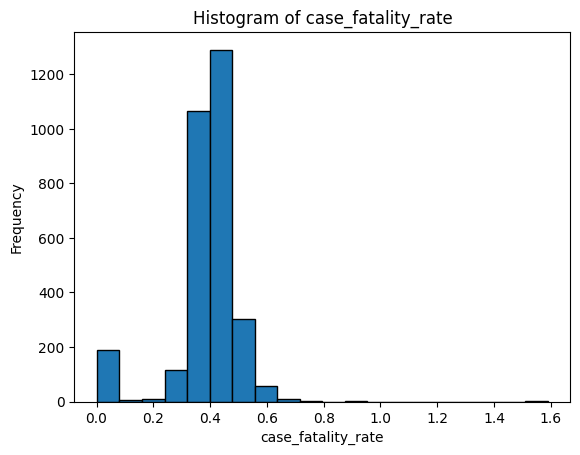

In [157]:
create_hist("case_fatality_rate")

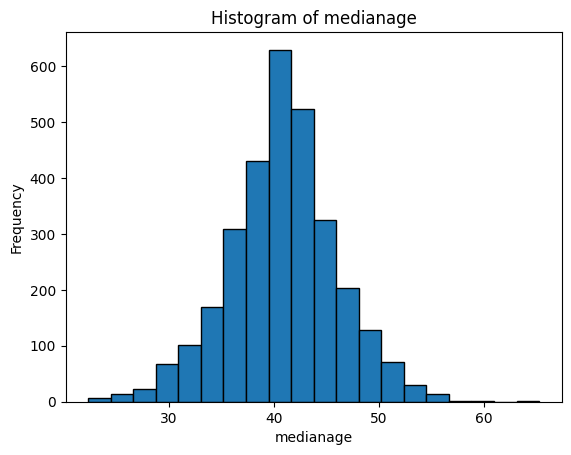

In [158]:
create_hist("medianage")
## Some data entry error for medianage

In [164]:
## What's up with the outlier, should we remove this row??
outlier = cancer_df[cancer_df["case_fatality_rate"] > 1.5]
print(outlier["geography"])
print(outlier["case_fatality_rate"])
print(cancer_df.loc[outlier.index])

112    Clark County, Nevada
Name: geography, dtype: object
112    1.589673
Name: case_fatality_rate, dtype: float64
     avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
112  1962.667684              3120             167.7     453.549422   

     medincome  popest2015  povertypercent  studypercap           binnedinc  \
112      51241     2114801            15.6   405.239075  (51046.4, 54545.6]   

     medianage  ...  log_medincome  avg_cases_per_100 avg_deaths_per_100  \
112       36.4  ...      10.844295           0.092806           0.147532   

     case_fatality_rate  income_group  public_only_reliance  \
112            1.589673          High                   Low   

     private_only_reliance   state  case_fatality_groups_three  \
112                 Middle  Nevada                        High   

     case_fatality_groups_five  
112                       High  

[1 rows x 42 columns]


In [169]:
cancer_df['z_scores'] = zscore(cancer_df['case_fatality_rate'])
outliers = cancer_df[abs(cancer_df['z_scores']) > 4]
print(outliers["geography"])
print(outliers["case_fatality_rate"])
print(outliers["z_scores"])
cancer_df.drop(columns=["z_scores"], inplace=True)

## While counties Bristol city, VA and Hennepin MN are both technically outliers with
## case fatality rates over 4 sd's above the mean, Clark County, NV is a whopping 10 sd above 
## the mean, indicating removal before analysis. Additionally, it doesn't make intuitive sense
## for Clark County to have a case fatality rate above 1, nevertheless 1.59. This would mean that 
## Clark County has more cancer deaths on average than cancer cases on average, which isn't
## feasible or possible. 

112           Clark County, Nevada
253         Bristol city, Virginia
2474    Hennepin County, Minnesota
Name: geography, dtype: object
112     1.589673
253     0.906250
2474    0.944633
Name: case_fatality_rate, dtype: float64
112     10.358717
253      4.462503
2474     4.793648
Name: z_scores, dtype: float64


In [40]:
## This county is very extreme (obs 112, Clark County Nevada), so lets remove it before running our analyis. This is worth noting however in the final 
## report, as it may have something to do with the extremely small case fatality rates in the rest of the Nevada counties. 
cancer_df = cancer_df[cancer_df['case_fatality_rate'] < 1.5]
cancer_df.shape

(3046, 42)

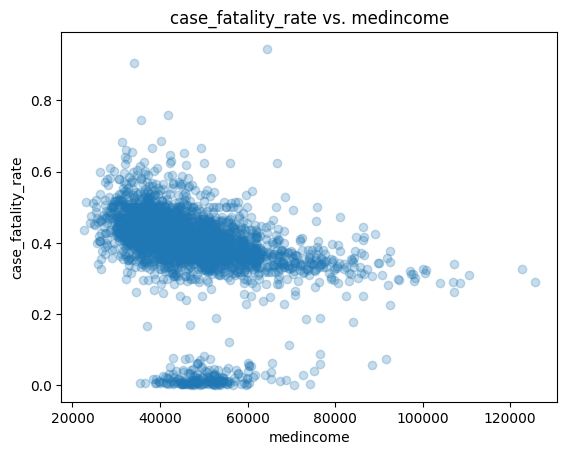

In [41]:
make_scatter("medincome", "case_fatality_rate")

In [42]:
## This code isn't used in the report. It created a standardized 'income' variable using the average of median income and pctprivatecoverage
## Then, it sees if this code is a significant predictor of case fatality rate

# Select variables related to medincome
related_vars = ['medincome', 'pctprivatecoverage']

# Standardize the variables
scaler = StandardScaler()
standardized_vars = scaler.fit_transform(cancer_df[related_vars])

# Create the composite variable
cancer_df['medincome_related_avg'] = standardized_vars.mean(axis=1)
cancer_df.head()

# Predict case fatality using the composite variable
X = sm.add_constant(cancer_df[['medincome_related_avg']])
y = cancer_df['case_fatality_rate']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     case_fatality_rate   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.146
Method:                 Least Squares   F-statistic:                     521.1
Date:                Thu, 27 Feb 2025   Prob (F-statistic):          1.34e-106
Time:                        11:57:32   Log-Likelihood:                 2536.7
No. Observations:                3046   AIC:                            -5069.
Df Residuals:                    3044   BIC:                            -5057.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.38

                            OLS Regression Results                            
Dep. Variable:     case_fatality_rate   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     362.6
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           1.81e-76
Time:                        11:57:33   Log-Likelihood:                 2467.4
No. Observations:                3046   AIC:                            -4931.
Df Residuals:                    3044   BIC:                            -4919.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3886      0.002    199.194      0.0

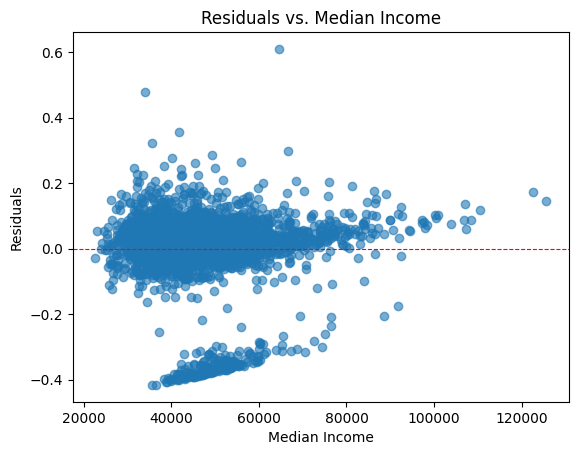

12041.829628786209


In [43]:
import statsmodels.api as sm

## This code chunk is testing if medincome is a significant predictor of case_fatality_rate by itself
## Standardize median income before fitting the model
X_scaled = scaler.fit_transform(cancer_df[['medincome']])
X_scaled = sm.add_constant(X_scaled)
y = cancer_df['case_fatality_rate']

# Re-run the regression
model = sm.OLS(y, X_scaled).fit()
print(model.summary())



# Prepare the data
#X = cancer_df[['medincome']]  # Predictor variables
#X = sm.add_constant(X)  # Add a constant term for the intercept
#y = cancer_df['case_fatality_rate']  # Target variable

# Fit the linear regression model
#model = sm.OLS(y, X).fit()

cancer_df['residuals'] = model.resid
plt.scatter(cancer_df['medincome'], cancer_df['residuals'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.xlabel('Median Income')
plt.ylabel('Residuals')
plt.title('Residuals vs. Median Income')
plt.show()

print(cancer_df["medincome"].std())

## Maybe do this for public health proportion and private health proportion also? 

                            OLS Regression Results                            
Dep. Variable:     case_fatality_rate   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     525.6
Date:                Thu, 27 Feb 2025   Prob (F-statistic):          1.98e-107
Time:                        11:57:34   Log-Likelihood:                 2538.6
No. Observations:                3046   AIC:                            -5073.
Df Residuals:                    3044   BIC:                            -5061.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3886      0.002    203.903      0.0

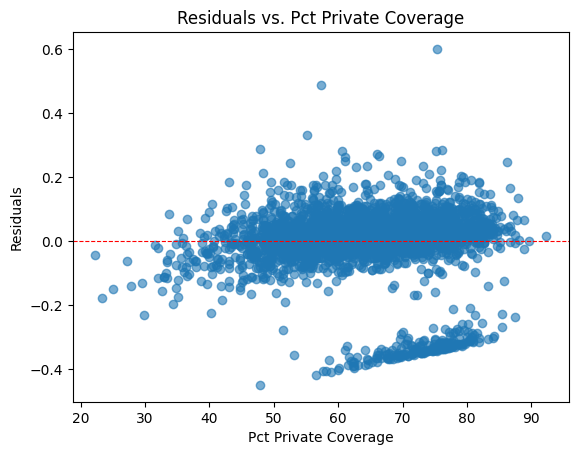

In [44]:
## Lets try fitting a model with pctprivatecoverage as the predictor

## This code chunk is testing if pctprivatecoverage is a significant predictor of case_fatality_rate by itself
y = cancer_df['case_fatality_rate']
X_scaled = scaler.fit_transform(cancer_df[['pctprivatecoverage']])
X_scaled = sm.add_constant(X_scaled)

# Re-run the regression
model = sm.OLS(y, X_scaled).fit()
print(model.summary())



# Prepare the data
#X = cancer_df[['medincome']]  # Predictor variables
#X = sm.add_constant(X)  # Add a constant term for the intercept
#y = cancer_df['case_fatality_rate']  # Target variable

# Fit the linear regression model
#model = sm.OLS(y, X).fit()

cancer_df['residuals'] = model.resid
plt.scatter(cancer_df['pctprivatecoverage'], cancer_df['residuals'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.xlabel('Pct Private Coverage')
plt.ylabel('Residuals')
plt.title('Residuals vs. Pct Private Coverage')
plt.show()

In [45]:
## Create a LR model exploring interactions between variables
# Create interaction terms
#cancer_df['medincome_x_poverty'] = cancer_df['medincome'] * cancer_df['povertypercent']
#cancer_df['private_x_public'] = cancer_df['pctprivatecoverage'] * cancer_df['pctpubliccoverage']
#cancer_df['poverty_x_public'] = cancer_df['povertypercent'] * cancer_df['pctpubliccoverage']

#cancer_df.head()

# Select predictors and interaction terms
#predictors = ['medincome', 'povertypercent', 'pctprivatecoverage', 
              #'medincome_x_poverty', 'private_x_public']

#X = cancer_df[predictors]
#X = sm.add_constant(X)
#y = cancer_df['case_fatality_rate']

# Fit the model
#model = sm.OLS(y, X).fit()
#print(model.summary())





## Let's investigate what is unique about this cluster of counties with case fatality rate < 0.1

## Maybe these counties just have a younger population? And thus are far less likely to die from cancer? 

low_fatality_df = cancer_df[cancer_df["case_fatality_rate"] < 0.1]
low_fatality_df

rest_fatality_df = cancer_df[cancer_df["case_fatality_rate"] >= 0.1]
rest_fatality_df

age_dict = {
    "low fatality group median age: " : low_fatality_df["medianage"].median, 
    "high fatality group median age: " : rest_fatality_df["medianage"].median
}

insurance_type_dict = {
    "low fatality median private insurance proportion: " : low_fatality_df["pctprivatecoverage"], 
    "high fatality median private insurance proportion: " : rest_fatality_df["pctprivatecoverage"]
}
## Perhaps the difference in private coverage pct is what's causing this extremely low fatality cluster
#insurance_type_dict

## Let's also check if these groups have different mediancomes

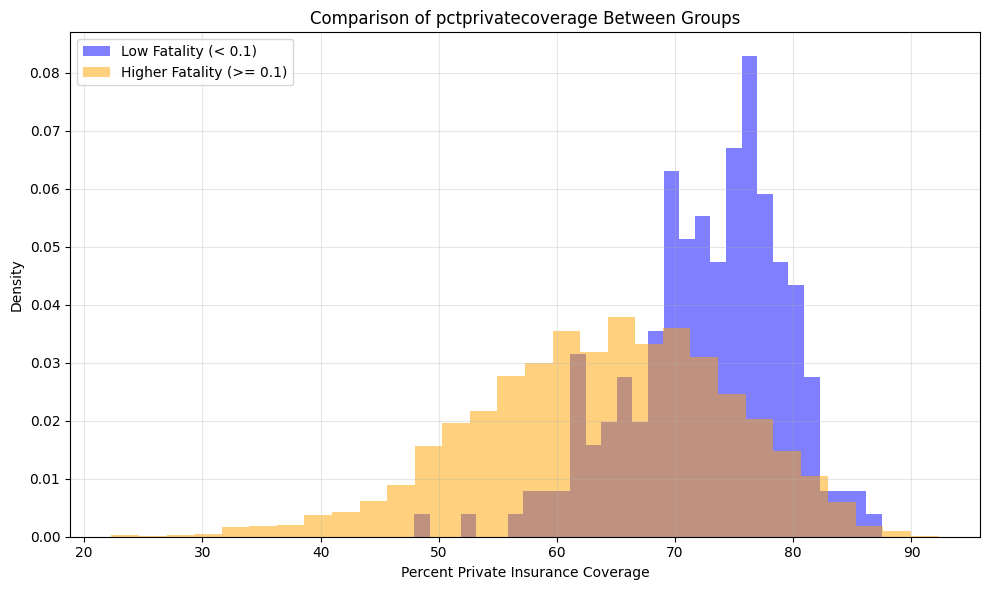

In [46]:
import matplotlib.pyplot as plt

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(low_fatality_df["pctprivatecoverage"], bins=30, alpha=0.5, label='Low Fatality (< 0.1)', color='blue', density=True)
plt.hist(rest_fatality_df["pctprivatecoverage"], bins=30, alpha=0.5, label='Higher Fatality (>= 0.1)', color='orange', density=True)
plt.xlabel('Percent Private Insurance Coverage')
plt.ylabel('Density')
plt.title('Comparison of pctprivatecoverage Between Groups')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

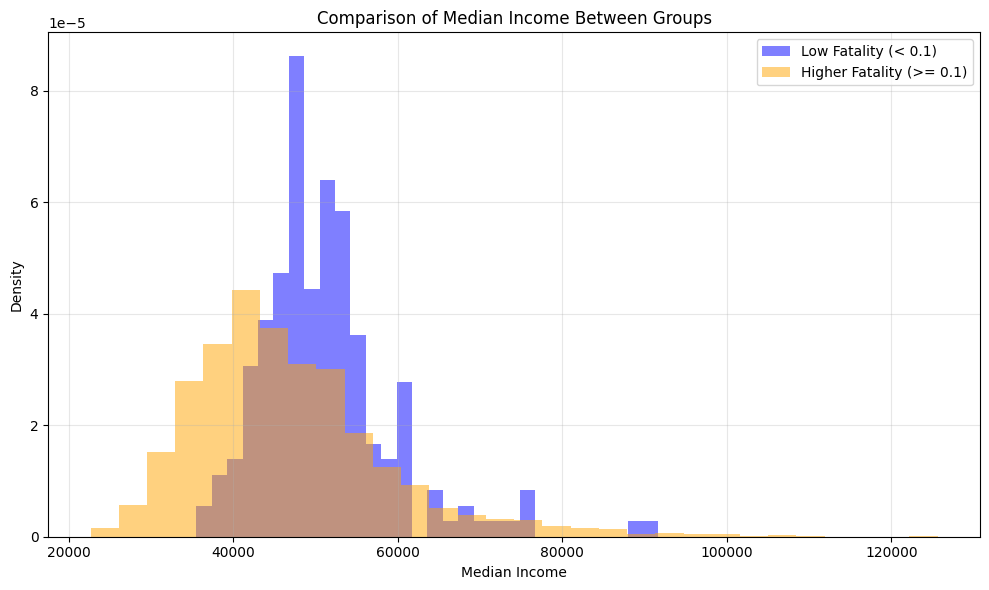

In [47]:
# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(low_fatality_df["medincome"], bins=30, alpha=0.5, label='Low Fatality (< 0.1)', color='blue', density=True)
plt.hist(rest_fatality_df["medincome"], bins=30, alpha=0.5, label='Higher Fatality (>= 0.1)', color='orange', density=True)
plt.xlabel('Median Income')
plt.ylabel('Density')
plt.title('Comparison of Median Income Between Groups')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [48]:
# Now we need to determine if we should compare the median private insurance pct or the mean between the low fatality and high fatality group
# Lets use shapiro test to see if these distributions are normal or not
# Test for normality
low_fatality_normality = shapiro(low_fatality_df["pctprivatecoverage"])
rest_fatality_normality = shapiro(rest_fatality_df["pctprivatecoverage"])

print(f"Low Fatality Normality Test p-value: {low_fatality_normality.pvalue}")
print(f"Rest Fatality Normality Test p-value: {rest_fatality_normality.pvalue}")

# From the results above, it seems that we should use a mann-whitney u test (compare the medians) to test if high fatality and low fatality groups 
# have significantly different pctprivatecoverage

Low Fatality Normality Test p-value: 0.001067820425789071
Rest Fatality Normality Test p-value: 8.973951180185928e-12


In [49]:
## Mann Whitney U test to test if higher fatality group and low fatality group have different pctprivatecoverage
# Extract the pctprivatecoverage for both groups
low_fatality_coverage = low_fatality_df['pctprivatecoverage']
rest_fatality_coverage = rest_fatality_df['pctprivatecoverage']

# Perform Mann-Whitney U Test
stat, p_value = mannwhitneyu(low_fatality_coverage, rest_fatality_coverage, alternative='two-sided')
print(f"Mann-Whitney U Statistic: {stat}, p-value: {p_value}")

Mann-Whitney U Statistic: 415168.5, p-value: 5.153186261333971e-33


In [50]:
low_fatality_df["state"].sample(60)

3046       Kansas
1301       Kansas
1299       Kansas
2457    Minnesota
2473    Minnesota
1310       Kansas
2513    Minnesota
117        Nevada
1294       Kansas
2462    Minnesota
1351       Kansas
2479    Minnesota
1327       Kansas
3042       Kansas
2485    Minnesota
121        Nevada
2508    Minnesota
1322       Kansas
3033       Kansas
3034       Kansas
2493    Minnesota
2454    Minnesota
369     Minnesota
2482    Minnesota
1296       Kansas
1309       Kansas
1332       Kansas
1319       Kansas
3044       Kansas
2515    Minnesota
2518    Minnesota
2464    Minnesota
2500    Minnesota
2480    Minnesota
2459    Minnesota
2525    Minnesota
2517    Minnesota
2472    Minnesota
1341       Kansas
2501    Minnesota
1345       Kansas
1297       Kansas
1344       Kansas
2483    Minnesota
3031       Kansas
124        Nevada
1304       Kansas
1302       Kansas
1295       Kansas
1360       Kansas
1323       Kansas
2481    Minnesota
3029       Kansas
1347       Kansas
1361       Kansas
3040      

In [51]:
# Filter cancer_df for counties in Nevada, Minnesota, or Kansas
states_of_interest = ['Nevada', 'Minnesota', 'Kansas']
filtered_cancer_df = cancer_df[cancer_df['geography'].apply(lambda x: x.split(', ')[1] in states_of_interest)]

# Identify counties in filtered_cancer_df that are NOT in low_fatality_df
not_in_low_fatality = filtered_cancer_df[~filtered_cancer_df['geography'].isin(low_fatality_df['geography'])]

# Count and display the result
num_not_in_low_fatality = not_in_low_fatality.shape[0]
print(f"Number of counties in Nevada, Minnesota, or Kansas in cancer_df but not in low_fatality_df: {num_not_in_low_fatality}")

# Optionally display these rows
print(not_in_low_fatality["geography"])


Number of counties in Nevada, Minnesota, or Kansas in cancer_df but not in low_fatality_df: 13
125            Washoe County, Nevada
368          Anoka County, Minnesota
1308          Johnson County, Kansas
1348         Sedgwick County, Kansas
1350          Shawnee County, Kansas
1366        Wyandotte County, Kansas
2466        Dakota County, Minnesota
2474      Hennepin County, Minnesota
2502       Olmsted County, Minnesota
2509        Ramsey County, Minnesota
2516     St. Louis County, Minnesota
2520       Stearns County, Minnesota
2529    Washington County, Minnesota
Name: geography, dtype: object


In [52]:
# So, there are 13 counties in cancer_df from either Kasnas, Minnesota, or Nevada that are not in low_fatality_df. 
# Subset the 13 rows
unique_counties = not_in_low_fatality

# Compare metrics between the unique counties and the rest
comparison_metrics = ['medincome', 'pctprivatecoverage', 'medianage', 'case_fatality_rate']  # Add relevant columns
unique_metrics = unique_counties[comparison_metrics].describe()
low_fatality_metrics = low_fatality_df[comparison_metrics].describe()

print("Metrics for unique counties:")
print(unique_metrics)
print("\nMetrics for low fatality counties:")
print(low_fatality_metrics)

Metrics for unique counties:
          medincome  pctprivatecoverage  medianage  case_fatality_rate
count     13.000000           13.000000  13.000000           13.000000
mean   61216.076923           74.261538  36.746154            0.321972
std    13437.068111            9.262607   2.194545            0.221118
min    37087.000000           51.400000  33.300000            0.114130
25%    52795.000000           69.200000  34.600000            0.176800
50%    55832.000000           75.400000  36.800000            0.253227
75%    70868.000000           80.400000  37.900000            0.405570
max    84113.000000           85.700000  40.900000            0.944633

Metrics for low fatality counties:
          medincome  pctprivatecoverage   medianage  case_fatality_rate
count    192.000000          192.000000  192.000000          192.000000
mean   51230.473958           72.667187   41.993229            0.021261
std     8447.569872            6.595200    5.440675            0.019583
min    3

In [53]:
# Let's try rerunning our Linear Regression, excluding states from minnesota, Nevada, and Kansas
# Exclude rows where the state is Minnesota, Nevada, or Kansas
excluded_states = ['Minnesota', 'Nevada', 'Kansas']

# Create a new dataframe excluding these states
cancer_df_excluded_states = cancer_df[~cancer_df['geography'].apply(lambda x: x.split(', ')[1]).isin(excluded_states)]

# Display the first few rows of the new dataframe
cancer_df_excluded_states.head()

# Optional: Save or analyze the new dataframe
cancer_df_excluded_states.to_csv('cancer_df_excluded_states.csv', index=False)
cancer_df_excluded_states["state"].value_counts()

state
Texas                   233
Georgia                 155
Virginia                125
Kentucky                120
Missouri                115
Illinois                102
Iowa                     99
North Carolina           99
Tennessee                95
Indiana                  92
Ohio                     87
Michigan                 83
Mississippi              82
Nebraska                 80
Oklahoma                 77
Arkansas                 75
Wisconsin                72
Pennsylvania             67
Florida                  66
Louisiana                64
Alabama                  63
New York                 62
Colorado                 60
South Dakota             59
California               57
West Virginia            55
North Dakota             51
Montana                  48
South Carolina           46
Idaho                    42
Washington               39
Oregon                   36
New Mexico               32
Utah                     27
Maryland                 24
Wyoming       

In [54]:
## This code chunk is testing if medincome is a significant predictor of case_fatality_rate by itself
## This is for the dataset excluding states Kansas, Nevada, and Minnesota, as there may be differences in health metric reporting or data entry 
## inaccuracy from those states
X_scaled = scaler.fit_transform(cancer_df_excluded_states[['medincome']])
X_scaled = sm.add_constant(X_scaled)
y = cancer_df_excluded_states['case_fatality_rate']

# Re-run the regression
model = sm.OLS(y, X_scaled).fit()
print(model.summary())
cancer_df_excluded_states.head()

print(cancer_df_excluded_states["medincome"].std())

                            OLS Regression Results                            
Dep. Variable:     case_fatality_rate   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.234
Method:                 Least Squares   F-statistic:                     866.4
Date:                Thu, 27 Feb 2025   Prob (F-statistic):          1.99e-166
Time:                        11:58:02   Log-Likelihood:                 4227.3
No. Observations:                2841   AIC:                            -8451.
Df Residuals:                    2839   BIC:                            -8439.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4137      0.001    403.430      0.0

C:\Users\zachw\AppData\Local\Temp\ipykernel_12672\1818576399.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df_excluded_states['residuals'] = model.resid


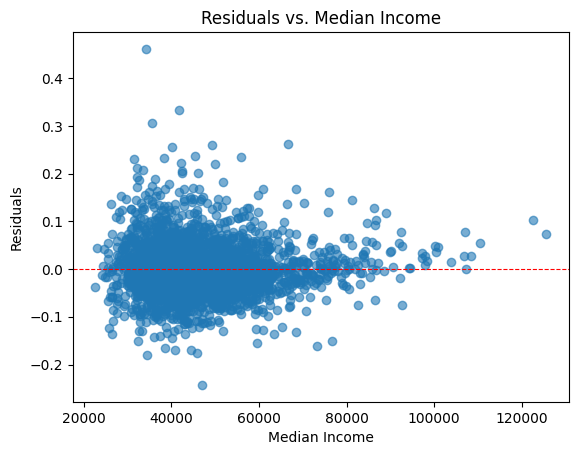

In [55]:
cancer_df_excluded_states['residuals'] = model.resid
plt.scatter(cancer_df_excluded_states['medincome'], cancer_df_excluded_states['residuals'], alpha=0.6)
plt.axhline(0, color='red', linestyle='--', linewidth=0.8)
plt.xlabel('Median Income')
plt.ylabel('Residuals')
plt.title('Residuals vs. Median Income')
plt.show()

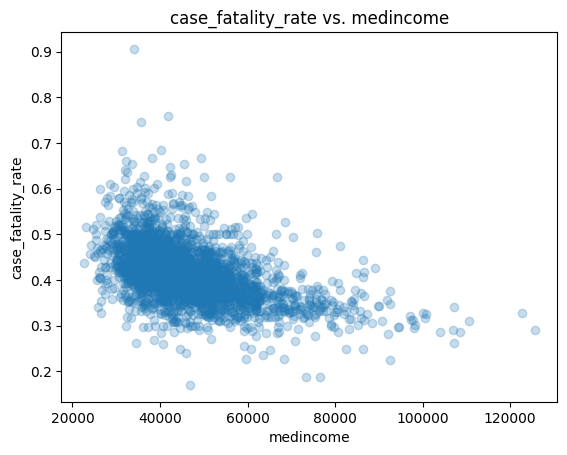

In [56]:
plt.scatter(cancer_df_excluded_states["medincome"], cancer_df_excluded_states["case_fatality_rate"], alpha=0.25)
plt.title("case_fatality_rate" + " vs. " + "medincome")
plt.xlabel("medincome")
plt.ylabel("case_fatality_rate")
plt.show()

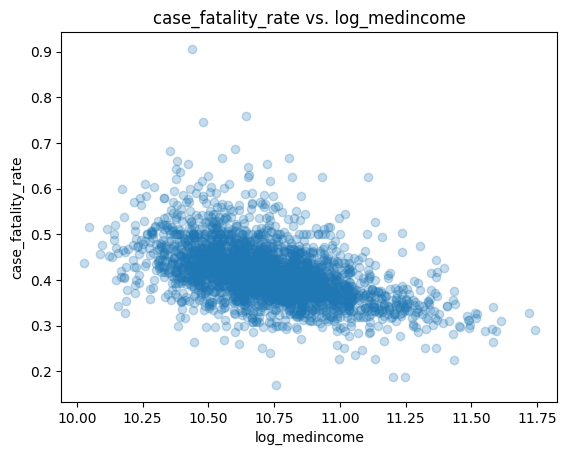

In [57]:
plt.scatter(cancer_df_excluded_states["log_medincome"], cancer_df_excluded_states["case_fatality_rate"], alpha=0.25)
plt.title("case_fatality_rate" + " vs. " + "log_medincome")
plt.xlabel("log_medincome")
plt.ylabel("case_fatality_rate")
plt.show()

In [58]:
# Lets try using log(median income) to predict case fatality

# Fit the model with log-transformed median income
X = cancer_df_excluded_states[['log_medincome']]
X = sm.add_constant(X)  # Add constant term
y = cancer_df_excluded_states['case_fatality_rate']

model_log = sm.OLS(y, X).fit()
print(model_log.summary())

                            OLS Regression Results                            
Dep. Variable:     case_fatality_rate   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     908.4
Date:                Thu, 27 Feb 2025   Prob (F-statistic):          2.20e-173
Time:                        11:58:05   Log-Likelihood:                 4243.3
No. Observations:                2841   AIC:                            -8483.
Df Residuals:                    2839   BIC:                            -8471.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.7846      0.045     39.226

In [59]:
# Lets try using median income to predict log(case fatality rate)

# Transform the dependent variable for an exponential model
cancer_df_excluded_states['log_case_fatality_rate'] = np.log(cancer_df_excluded_states['case_fatality_rate'])

# Fit the model
X = cancer_df_excluded_states[['medincome']]
X = sm.add_constant(X)  # Add constant term
y = cancer_df_excluded_states['log_case_fatality_rate']

model_exp = sm.OLS(y, X).fit()
print(model_exp.summary())

                              OLS Regression Results                              
Dep. Variable:     log_case_fatality_rate   R-squared:                       0.255
Model:                                OLS   Adj. R-squared:                  0.255
Method:                     Least Squares   F-statistic:                     974.0
Date:                    Thu, 27 Feb 2025   Prob (F-statistic):          4.23e-184
Time:                            11:58:06   Log-Likelihood:                 1794.4
No. Observations:                    2841   AIC:                            -3585.
Df Residuals:                        2839   BIC:                            -3573.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       

C:\Users\zachw\AppData\Local\Temp\ipykernel_12672\2827372752.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df_excluded_states['log_case_fatality_rate'] = np.log(cancer_df_excluded_states['case_fatality_rate'])


In [60]:
# Now lets try building a polynomial model to predict some function of median income on case fatality. Later, try to use this model to see how 
# accuratly it can classify case_fatality_groups_three and case_fatality_groups_five
cancer_df_excluded_states.columns

Index(['avganncount', 'avgdeathsperyear', 'target_deathrate', 'incidencerate',
       'medincome', 'popest2015', 'povertypercent', 'studypercap', 'binnedinc',
       'medianage', 'medianagemale', 'medianagefemale', 'geography',
       'percentmarried', 'pctnohs18_24', 'pcths18_24', 'pctbachdeg18_24',
       'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over',
       'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone',
       'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone',
       'pctwhite', 'pctblack', 'pctasian', 'pctotherrace',
       'pctmarriedhouseholds', 'birthrate', 'log_medincome',
       'avg_cases_per_100', 'avg_deaths_per_100', 'case_fatality_rate',
       'income_group', 'public_only_reliance', 'private_only_reliance',
       'state', 'case_fatality_groups_three', 'case_fatality_groups_five',
       'medincome_related_avg', 'residuals', 'log_case_fatality_rate'],
      dtype='object')

Best Polynomial Degree: 4
Validation MSE for Best Degree: 0.002975227000966212
Test MSE for Best Degree: 0.003207190605333562
Test RMSE for Best Degree: 0.05663206340346043
Standard Deviation of Test Set: 0.0622234123746573


C:\Users\zachw\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


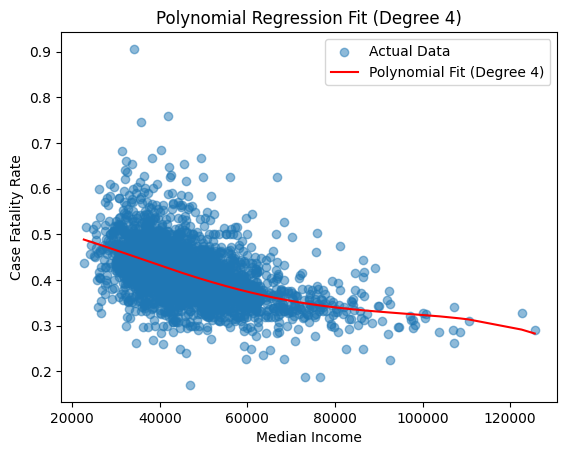

          1         2         3         4         5
0  0.003001  0.002978  0.002979  0.002975  0.002976


In [61]:
# Prepare the data
X = cancer_df_excluded_states[['medincome']]
y = cancer_df_excluded_states['case_fatality_rate']

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tune the degree hyperparameter using the validation set
best_degree = None
best_val_mse = float('inf')
val_mse_dct = {}

for degree in range(1, 6):  # Try polynomial degrees from 1 to 5
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    model_poly = LinearRegression()
    model_poly.fit(X_train_poly, y_train)

    y_val_pred = model_poly.predict(X_val_poly)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mse_dct[str(degree)] = val_mse

    if val_mse < best_val_mse:
        best_val_mse = val_mse
        best_degree = degree

# Train the final model using the optimal degree
poly_optimal = PolynomialFeatures(degree=best_degree)
X_train_poly_optimal = poly_optimal.fit_transform(X_train)
X_test_poly_optimal = poly_optimal.transform(X_test)

model_poly_optimal = LinearRegression()
model_poly_optimal.fit(X_train_poly_optimal, y_train)

# Evaluate the model on the test set
y_test_pred = model_poly_optimal.predict(X_test_poly_optimal)
test_mse = mean_squared_error(y_test, y_test_pred)

# Output the results
print(f"Best Polynomial Degree: {best_degree}")
print(f"Validation MSE for Best Degree: {best_val_mse}")
print(f"Test MSE for Best Degree: {test_mse}")
print(f"Test RMSE for Best Degree: {(test_mse ** 0.5)}")

test_variability = y_test.std()
print(f"Standard Deviation of Test Set: {test_variability}")

# Visualize the polynomial regression fit
X_sorted = np.sort(X, axis=0)
X_sorted_poly = poly_optimal.transform(X_sorted)
y_sorted_pred = model_poly_optimal.predict(X_sorted_poly)

plt.scatter(X, y, alpha=0.5, label='Actual Data')
plt.plot(X_sorted, y_sorted_pred, color='red', label=f'Polynomial Fit (Degree {best_degree})')
plt.xlabel('Median Income')
plt.ylabel('Case Fatality Rate')
plt.title(f'Polynomial Regression Fit (Degree {best_degree})')
plt.legend()
plt.show()


df_degree_comparisons = pd.DataFrame.from_dict(val_mse_dct, orient='index').transpose()
print(df_degree_comparisons)

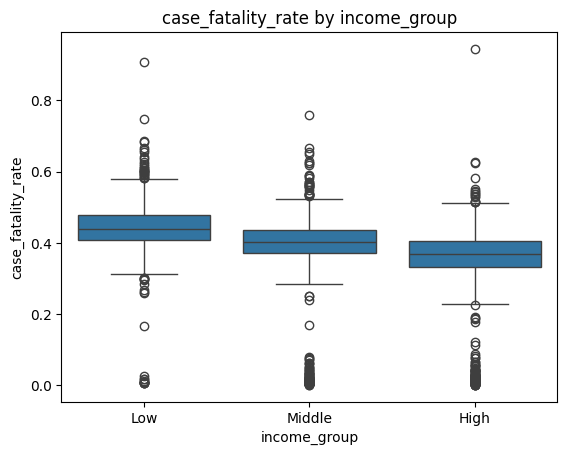

In [62]:
## Create boxplot comparisons for case fatality rate for different income groups

## Maybe use cancer_df_excluded_states for this anova section and visualizations

def make_boxplots(x_var, y_var):
    sns.boxplot(x=x_var, y=y_var, data=cancer_df)
    plt.title(y_var + " by " + x_var)
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.show()

make_boxplots("income_group", "case_fatality_rate")

In [63]:
## Add a violin plot??


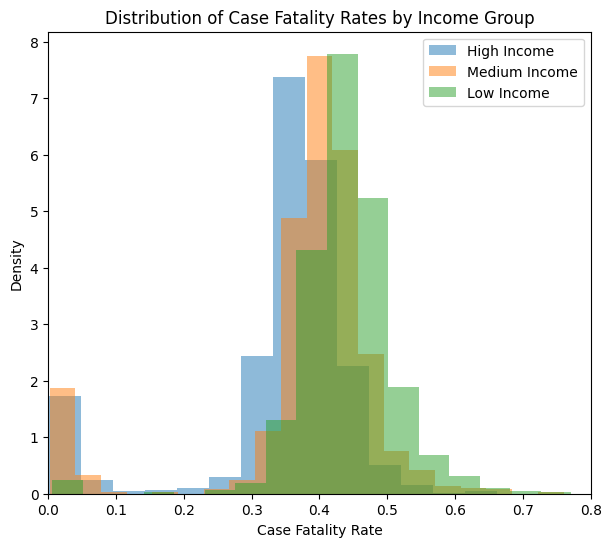

In [64]:
# Define subsets for case fatality rates by income group

## Maybe run these ANCOVA (or ANOVA) tests using cancer_df_excluded_states

high_income_cfr = cancer_df[cancer_df['income_group'] == 'High']['case_fatality_rate']
medium_income_cfr = cancer_df[cancer_df['income_group'] == 'Middle']['case_fatality_rate']
low_income_cfr = cancer_df[cancer_df['income_group'] == 'Low']['case_fatality_rate']

# Plot overlayed histograms
plt.figure(figsize=(7, 6))
# Set x-axis limit
plt.xlim(0, 0.8)

plt.hist(high_income_cfr, bins=20, alpha=0.5, label='High Income', density=True)
plt.hist(medium_income_cfr, bins=20, alpha=0.5, label='Medium Income', density=True)
plt.hist(low_income_cfr, bins=20, alpha=0.5, label='Low Income', density=True)

# Add labels, legend, and title
plt.xlabel('Case Fatality Rate')
plt.ylabel('Density')
plt.title('Distribution of Case Fatality Rates by Income Group')
plt.legend()
plt.show()

In [65]:
## ANOVA F-test for testing fatality rate across different income groups. 
## Could I also do this for other variables besides income groups? Are we only seeing significant differences because of a huge sample size? 
from scipy.stats import f_oneway

low_income = cancer_df[cancer_df['income_group'] == 'Low']['case_fatality_rate']
middle_income = cancer_df[cancer_df['income_group'] == 'Middle']['case_fatality_rate']
high_income = cancer_df[cancer_df['income_group'] == 'High']['case_fatality_rate']

f_stat, p_value = f_oneway(low_income, middle_income, high_income)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

## Assumptions seem to be met:
## The responses for each factor level have a normal population distribution.
## These distributions have the same variance.
## The data are independent.
## The values of the dependent variable follow a normal distribution.
## The variation within each group being compared is similar for every group.
## The different groups/levels must have equal sample sizes.
## Population variances must be equal (i.e., homoscedastic).
## The observations are independent of each other.

F-statistic: 209.74467849027158, P-value: 4.617407381951171e-86


In [66]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_income = pairwise_tukeyhsd(endog=cancer_df['case_fatality_rate'],
                          groups=cancer_df['income_group'],
                          alpha=0.05)
print(tukey_income)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  High    Low   0.0958   0.0  0.0847  0.1069   True
  High Middle   0.0342   0.0  0.0231  0.0454   True
   Low Middle  -0.0615   0.0 -0.0727 -0.0504   True
---------------------------------------------------


In [67]:
# Add the covariate (Age) to the dataset if not already there
# Ensure that 'age' is included in your dataframe columns

# Define the formula for ANCOVA
formula = 'case_fatality_rate ~ income_group + medianage'

# Fit the ANCOVA model
ancova_model = ols.ols(formula=formula, data=cancer_df).fit()

# Print the summary of the ANCOVA
print(ancova_model.summary())

# Get an ANOVA table for the ANCOVA model
ancova_table = sm.stats.anova_lm(ancova_model, typ=2)  # Type II sums of squares
print(ancova_table)

                            OLS Regression Results                            
Dep. Variable:     case_fatality_rate   R-squared:                       0.121
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     139.8
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           6.98e-85
Time:                        11:58:11   Log-Likelihood:                 2492.8
No. Observations:                3046   AIC:                            -4978.
Df Residuals:                    3042   BIC:                            -4953.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0

In [68]:
# Obtain residuals and adjust them
residuals = ancova_model.resid
#print(residuals)
adjusted_case_fatality_rate = ancova_model.resid + ancova_model.fittedvalues.mean()

# Perform Tukey's HSD test
tukey_test = pairwise_tukeyhsd(
    endog=adjusted_case_fatality_rate,  # Adjusted case fatality rates
    groups=cancer_df['income_group'],  # Income groups
    alpha=0.05  # Significance level
)

# Print results
print(tukey_test)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
  High    Low     -0.0   1.0 -0.0111 0.0111  False
  High Middle     -0.0   1.0 -0.0111 0.0111  False
   Low Middle     -0.0   1.0 -0.0111 0.0111  False
--------------------------------------------------


In [69]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3046 entries, 0 to 3046
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   avganncount                 3046 non-null   float64 
 1   avgdeathsperyear            3046 non-null   int64   
 2   target_deathrate            3046 non-null   float64 
 3   incidencerate               3046 non-null   float64 
 4   medincome                   3046 non-null   int64   
 5   popest2015                  3046 non-null   int64   
 6   povertypercent              3046 non-null   float64 
 7   studypercap                 3046 non-null   float64 
 8   binnedinc                   3046 non-null   object  
 9   medianage                   3046 non-null   float64 
 10  medianagemale               3046 non-null   float64 
 11  medianagefemale             3046 non-null   float64 
 12  geography                   3046 non-null   object  
 13  percentmarried         

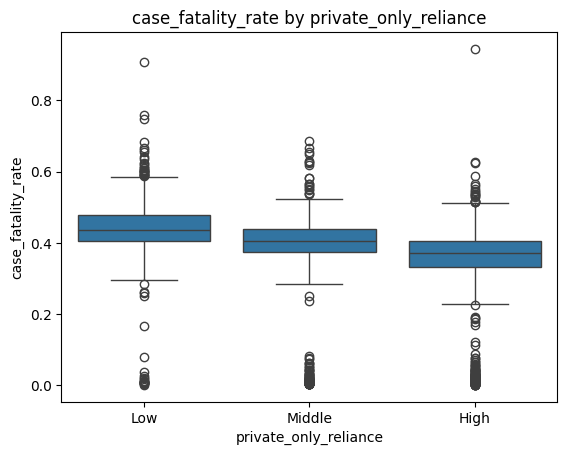

In [70]:
## Now, I can compare case_fatality_rates for high, medium, and low levels of private_only_reliance

make_boxplots("private_only_reliance", "case_fatality_rate")

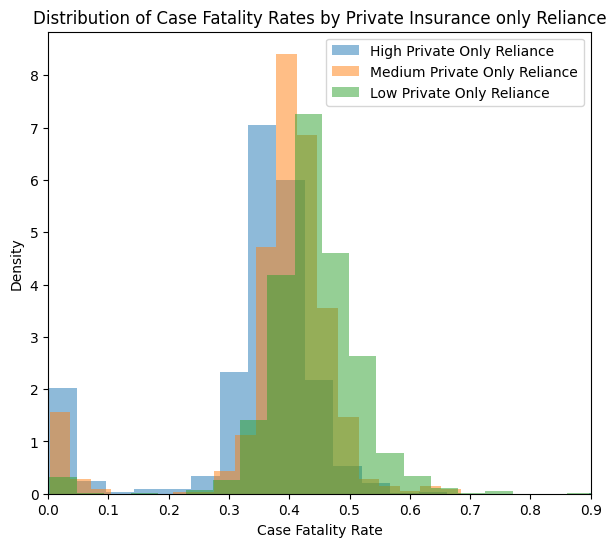

In [71]:
# Define subsets for case fatality rates by income group
high_private_only_reliance = cancer_df[cancer_df['private_only_reliance'] == 'High']['case_fatality_rate']
medium_private_only_reliance = cancer_df[cancer_df['private_only_reliance'] == 'Middle']['case_fatality_rate']
low_private_only_reliance = cancer_df[cancer_df['private_only_reliance'] == 'Low']['case_fatality_rate']

# Plot overlayed histograms
plt.figure(figsize=(7, 6))
# Set x-axis limit
plt.xlim(0, 0.9)

plt.hist(high_private_only_reliance, bins=20, alpha=0.5, label='High Private Only Reliance', density=True)
plt.hist(medium_private_only_reliance, bins=20, alpha=0.5, label='Medium Private Only Reliance', density=True)
plt.hist(low_private_only_reliance, bins=20, alpha=0.5, label='Low Private Only Reliance', density=True)

# Add labels, legend, and title
plt.xlabel('Case Fatality Rate')
plt.ylabel('Density')
plt.title('Distribution of Case Fatality Rates by Private Insurance only Reliance')
plt.legend()
plt.show()

In [72]:
## Now, is the difference between these groups statistically significant? 

f_stat_private_only, p_value_private_only = f_oneway(low_private_only_reliance, medium_private_only_reliance, high_private_only_reliance)

print(f"F-statistic: {f_stat_private_only}, P-value: {p_value_private_only}")

F-statistic: 208.10060850007022, P-value: 1.9597590424582946e-85


In [73]:
tukey_private_only_reliance = pairwise_tukeyhsd(endog=cancer_df['case_fatality_rate'],
                          groups=cancer_df['private_only_reliance'],
                          alpha=0.05)
print(tukey_private_only_reliance)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  High    Low   0.0967   0.0  0.0856  0.1078   True
  High Middle   0.0458   0.0  0.0347  0.0569   True
   Low Middle  -0.0509   0.0 -0.0621 -0.0398   True
---------------------------------------------------


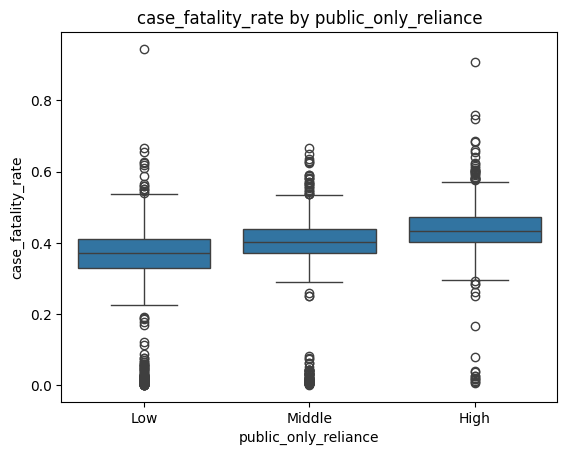

In [74]:
## Now, I can compare case_fatality_rates for high, medium, and low levels of public_only_reliance

make_boxplots("public_only_reliance", "case_fatality_rate")

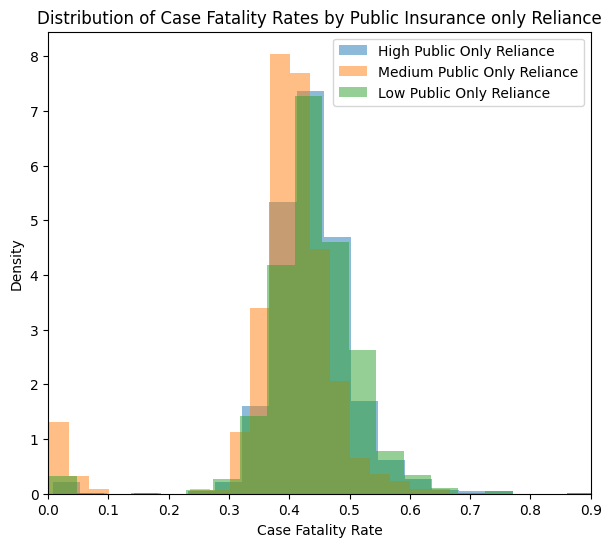

avganncount  avgdeathsperyear  target_deathrate  incidencerate  medincome  \
0       1397.0               469             164.9          489.8      61898   
1        173.0                70             161.3          411.6      48127   
2        102.0                50             174.7          349.7      49348   
3        427.0               202             194.8          430.4      44243   
4         57.0                26             144.4          350.1      49955   

   popest2015  povertypercent  studypercap           binnedinc  medianage  \
0      260131            11.2   499.748204   (61494.5, 125635]       39.3   
1       43269            18.6    23.111234  (48021.6, 51046.4]       33.0   
2       21026            14.6    47.560164  (48021.6, 51046.4]       45.0   
3       75882            17.1   342.637253    (42724.4, 45201]       42.8   
4       10321            12.5     0.000000  (48021.6, 51046.4]       48.3   

   ...  avg_deaths_per_100  case_fatality_rate income_group  \
0  ...            0.180294            0.335719         High   
1  ...            0.161779            0.404624       Middle   
2  ...            0.237801            0.490196       Middle   
3  ...            0.266203            0.473068       Middle   
4  ...            0.251914            0.456140       Middle   

   public_only_reliance  private_only_reliance       state  \
0                   Low                   High  Washington   
1                   Low                   High  Washington   
2                Middle                    Low  Washington   
3                  High                    Low  Washington   
4                  High                    Low  Washington   

   case_fatality_groups_three  case_fatality_groups_five  \
0                         Low                        Low   
1                      Middle                     Middle   
2                        High                       High   
3                        High                       High   
4                        High                       High   

   medincome_related_avg  residuals  
0               1.120706  -0.008800  
1               0.318702   0.039996  
2               0.064159   0.098894  
3              -0.396741   0.060016  
4              -0.009252   0.056220  

[5 rows x 44 columns]

In [75]:
# Define subsets for case fatality rates by public only reliance
high_public_only_reliance = cancer_df[cancer_df['public_only_reliance'] == 'High']['case_fatality_rate']
medium_public_only_reliance = cancer_df[cancer_df['public_only_reliance'] == 'Middle']['case_fatality_rate']
low_public_only_reliance = cancer_df[cancer_df['private_only_reliance'] == 'Low']['case_fatality_rate']

# Plot overlayed histograms
plt.figure(figsize=(7, 6))
# Set x-axis limit
plt.xlim(0, 0.9)

plt.hist(high_public_only_reliance, bins=20, alpha=0.5, label='High Public Only Reliance', density=True)
plt.hist(medium_public_only_reliance, bins=20, alpha=0.5, label='Medium Public Only Reliance', density=True)
plt.hist(low_public_only_reliance, bins=20, alpha=0.5, label='Low Public Only Reliance', density=True)

# Add labels, legend, and title
plt.xlabel('Case Fatality Rate')
plt.ylabel('Density')
plt.title('Distribution of Case Fatality Rates by Public Insurance only Reliance')
plt.legend()
plt.show()

cancer_df.head()

In [76]:
## Now, is the difference between these groups statistically significant? 

f_stat_public_only, p_value_public_only = f_oneway(low_public_only_reliance, medium_public_only_reliance, high_public_only_reliance)

print(f"F-statistic: {f_stat_public_only}, P-value: {p_value_public_only}")

F-statistic: 93.63083204435664, P-value: 3.4695670512491487e-40


In [77]:
tukey_public_only_reliance = pairwise_tukeyhsd(endog=cancer_df['case_fatality_rate'],
                          groups=cancer_df['public_only_reliance'],
                          alpha=0.05)
print(tukey_public_only_reliance)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  High    Low  -0.0957   0.0 -0.1068 -0.0846   True
  High Middle  -0.0455   0.0 -0.0567 -0.0344   True
   Low Middle   0.0502   0.0   0.039  0.0613   True
---------------------------------------------------


In [78]:


## From here on out it is LASSO MODEL BUILDING and MODEL ANALYSIS



## Some things I am concerned about/what I am planning...
## Conducting a large amount of frequentist significance tests might be problematic - might have to reduce individual significane levels to decrease
## Chance of making a type 1 error

##I want to make a linear regression model to predict case fatality rate. Since there are so many variables, I might have to use stepwise regression
##or another regression technique (bayes??) to find the best model (minimize mse?) while also limiting the amount of variables in the model.

## Additionally I should use k-fold cross validation to find the best model. Maybe talk with Naomi about best way to do this...
## Want to do some sort of regression to find the best set of predictors for predicting case_fatality_rate...
## Lasso regression!



## Maybe lets try using log(medincome) rather than medincome because Lasso Regression is assuming a linear relationship between the predictor and 
## case_fatality

cancer_df.columns
cancer_df = cancer_df.drop(columns=["medincome_related_avg"])
cancer_df.columns

Index(['avganncount', 'avgdeathsperyear', 'target_deathrate', 'incidencerate',
       'medincome', 'popest2015', 'povertypercent', 'studypercap', 'binnedinc',
       'medianage', 'medianagemale', 'medianagefemale', 'geography',
       'percentmarried', 'pctnohs18_24', 'pcths18_24', 'pctbachdeg18_24',
       'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over',
       'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone',
       'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone',
       'pctwhite', 'pctblack', 'pctasian', 'pctotherrace',
       'pctmarriedhouseholds', 'birthrate', 'log_medincome',
       'avg_cases_per_100', 'avg_deaths_per_100', 'case_fatality_rate',
       'income_group', 'public_only_reliance', 'private_only_reliance',
       'state', 'case_fatality_groups_three', 'case_fatality_groups_five',
       'residuals'],
      dtype='object')

In [79]:
# cancer_df is the DataFrame and "case_fatality_rate" is the target variable.
## We will only consider the quantitative predictors, not the categorical ones
## Lets also consider dropping average ann cases and average deaths per year because our target variable (case fatality rate) is directly derived from 
## these variables. Otherwise, these two variables would dominate our model. 
predictors = cancer_df.drop(columns=["case_fatality_rate", "binnedinc", "geography", "income_group", "public_only_reliance", "private_only_reliance", "avganncount", "avgdeathsperyear", "avg_deaths_per_100", "avg_cases_per_100", "target_deathrate", "log_medincome", "state", "case_fatality_groups_three", "case_fatality_groups_five", "residuals"])
y = cancer_df["case_fatality_rate"]

# Add a constant for the intercept in regression models.
predictors = sm.add_constant(predictors)

predictors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3046 entries, 0 to 3046
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   const                    3046 non-null   float64
 1   incidencerate            3046 non-null   float64
 2   medincome                3046 non-null   int64  
 3   popest2015               3046 non-null   int64  
 4   povertypercent           3046 non-null   float64
 5   studypercap              3046 non-null   float64
 6   medianage                3046 non-null   float64
 7   medianagemale            3046 non-null   float64
 8   medianagefemale          3046 non-null   float64
 9   percentmarried           3046 non-null   float64
 10  pctnohs18_24             3046 non-null   float64
 11  pcths18_24               3046 non-null   float64
 12  pctbachdeg18_24          3046 non-null   float64
 13  pcths25_over             3046 non-null   float64
 14  pctbachdeg25_over        3046

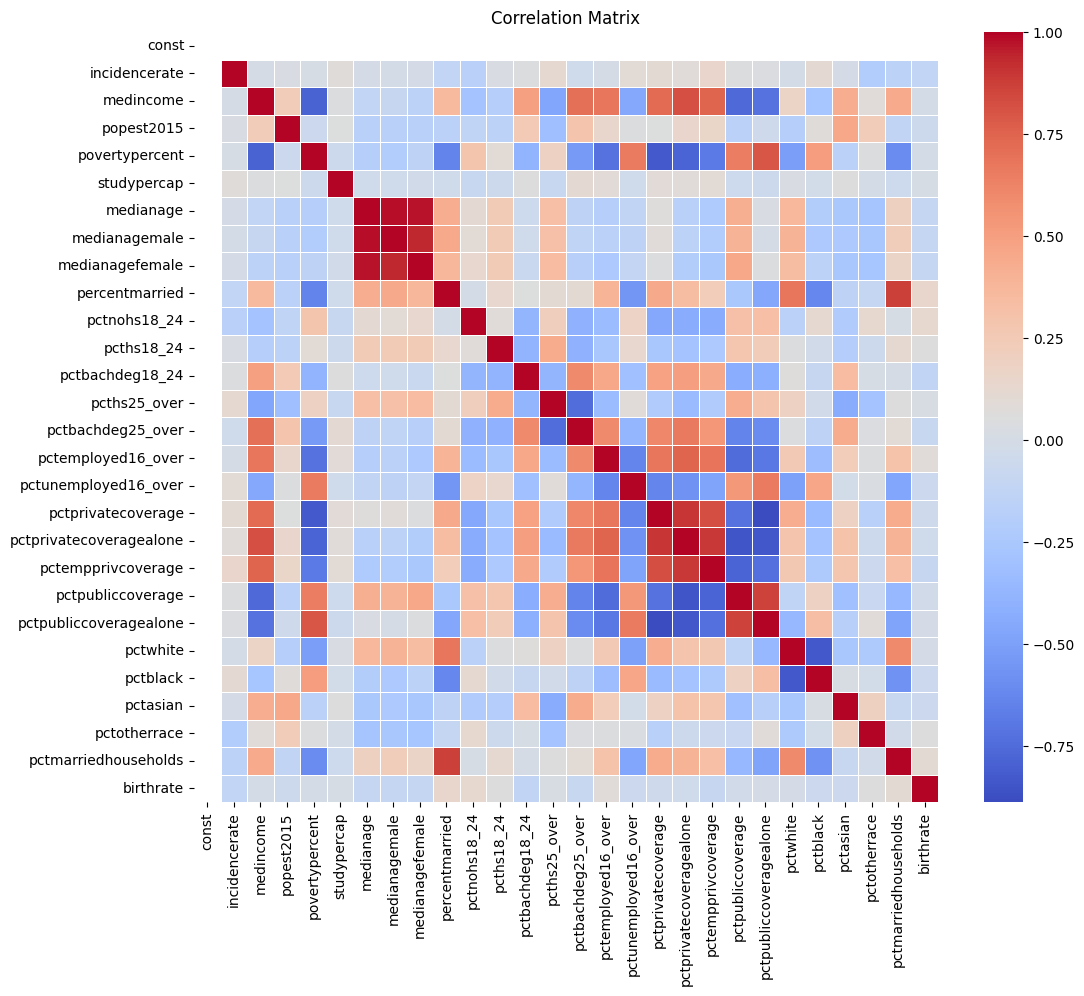

In [80]:
## Lets try to eliminate some features here (avoiding multicollinearity)
## Build a correlation matrix to see which features are correlated with eachother
corr_matrix = predictors.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [81]:
high_corr_pairs = corr_matrix.unstack().reset_index()
high_corr_pairs.columns = ["Variable 1", "Variable 2", "Correlation"]
high_corr_pairs = high_corr_pairs[
    (abs(high_corr_pairs["Correlation"]) > 0.7) & (high_corr_pairs["Variable 1"] != high_corr_pairs["Variable 2"])
]
print(high_corr_pairs)

                  Variable 1               Variable 2  Correlation
60                 medincome           povertypercent    -0.788963
70                 medincome        pctbachdeg25_over     0.704917
73                 medincome       pctprivatecoverage     0.724207
74                 medincome  pctprivatecoveragealone     0.818563
75                 medincome       pctempprivcoverage     0.747282
76                 medincome        pctpubliccoverage    -0.754868
77                 medincome   pctpubliccoveragealone    -0.719743
114           povertypercent                medincome    -0.788963
127           povertypercent       pctemployed16_over    -0.720176
129           povertypercent       pctprivatecoverage    -0.822551
130           povertypercent  pctprivatecoveragealone    -0.776216
133           povertypercent   pctpubliccoveragealone     0.798649
175                medianage            medianagemale     0.979565
176                medianage          medianagefemale     0.97

In [82]:
## Now, rather than using PCA or some other method, I will choose median_income as the representitive for all income related variables.
## So, I will drop all variables with a correlation abs(r) >= 0.7
## Lets try dropping pctunemployed16_over for now
predictors = predictors.drop(columns=["pctpubliccoveragealone", "povertypercent", "pctbachdeg25_over", "pctprivatecoverage", "pctprivatecoveragealone", "pctempprivcoverage", "pctpubliccoverage", "pctpubliccoveragealone", "medianagemale", "medianagefemale", "pctmarriedhouseholds", "pctblack", "pctemployed16_over", "pctunemployed16_over"])
predictors.columns

Index(['const', 'incidencerate', 'medincome', 'popest2015', 'studypercap',
       'medianage', 'percentmarried', 'pctnohs18_24', 'pcths18_24',
       'pctbachdeg18_24', 'pcths25_over', 'pctwhite', 'pctasian',
       'pctotherrace', 'birthrate'],
      dtype='object')

In [83]:
corr_matrix2 = predictors.corr()

high_corr_pairs2 = corr_matrix2.unstack().reset_index()
high_corr_pairs2.columns = ["Variable 1", "Variable 2", "Correlation"]
high_corr_pairs2 = high_corr_pairs2[
    (abs(high_corr_pairs2["Correlation"]) > 0.7) & (high_corr_pairs2["Variable 1"] != high_corr_pairs2["Variable 2"])
]
print(high_corr_pairs2)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []


In [84]:
## 70% of predictor data will go to X_train, 70% of case_fatality will go to y_train, the rest will go to X_temp and y_temp, 
## which will be further split up into validation set (used for tuning hyperparameters, like alpha (penalty term in Lasso)), 
## and testing set, which is used to evaluate how well the model generalizes to unseen data
X_train, X_temp, y_train, y_temp = train_test_split(predictors, y, test_size=0.3, random_state=23)

## 15% of overall data to validation set, 15% of overall data to test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)


In [85]:
## Now, we need to standardize our feature variables to ensure that lasso penaltizes each feature fairly
## Lasso penalizes coefficients based on their magnitude, so features need to be on the same scale to ensure fair penalization. 
## Without scaling, a variable with a large range (e.g., income) might dominate the penalty term.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [86]:
alpha_values = np.logspace(-4, 1, 50)
validation_errors = []

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, random_state=23, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_val_pred = lasso.predict(X_val_scaled)
    val_mse = mean_squared_error(y_val, y_val_pred)
    validation_errors.append(val_mse)

#alpha_values
len(validation_errors)

50

In [87]:
#best_alpha = alpha_values[np.argmin(validation_errors)]

## Let's try the midpoint alpha value first to balance a small mse without reducing our coeffecients too much
midpoint_index = int((len(validation_errors) / 2))
midpoint_alpha = alpha_values[midpoint_index]
midpoint_alpha

## Now, lets try using the best alpha to see what coeffecients remain
best_alpha = alpha_values[np.argmin(validation_errors)]
#best_alpha

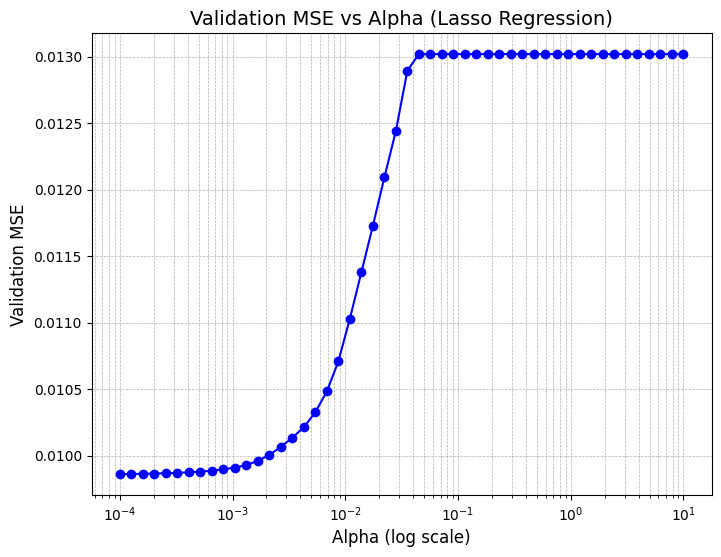

In [88]:
# Assuming alpha_values and validation_errors are already defined
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(alpha_values, validation_errors, marker='o', linestyle='-', color='b')  # Create the line plot
plt.xscale('log')  # Set the x-axis to a logarithmic scale for alpha
plt.xlabel('Alpha (log scale)', fontsize=12)  # Label for x-axis
plt.ylabel('Validation MSE', fontsize=12)  # Label for y-axis
plt.title('Validation MSE vs Alpha (Lasso Regression)', fontsize=14)  # Title of the plot
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid for better readability
plt.show()

In [89]:
## Alpha parameter decides what alpha we are using
lasso_best = Lasso(alpha=midpoint_alpha, random_state=23, max_iter=10000)
lasso_best.fit(X_train_scaled, y_train)

Lasso(alpha=np.float64(0.03556480306223128), max_iter=10000, random_state=23)

In [90]:
y_test_pred = lasso_best.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mse

0.012427807957399723

In [91]:
## Now we will see which coeffecients are retained
coefficients = lasso_best.coef_

feature_names = X_train.columns  # Replace with the names of your features
retained_features = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

retained_features = retained_features[retained_features["Coefficient"] != 0]
print(retained_features)

retained_features = retained_features.sort_values(by="Coefficient", ascending=True)
retained_features

     Feature  Coefficient
2  medincome    -0.001755


Feature  Coefficient
2  medincome    -0.001755

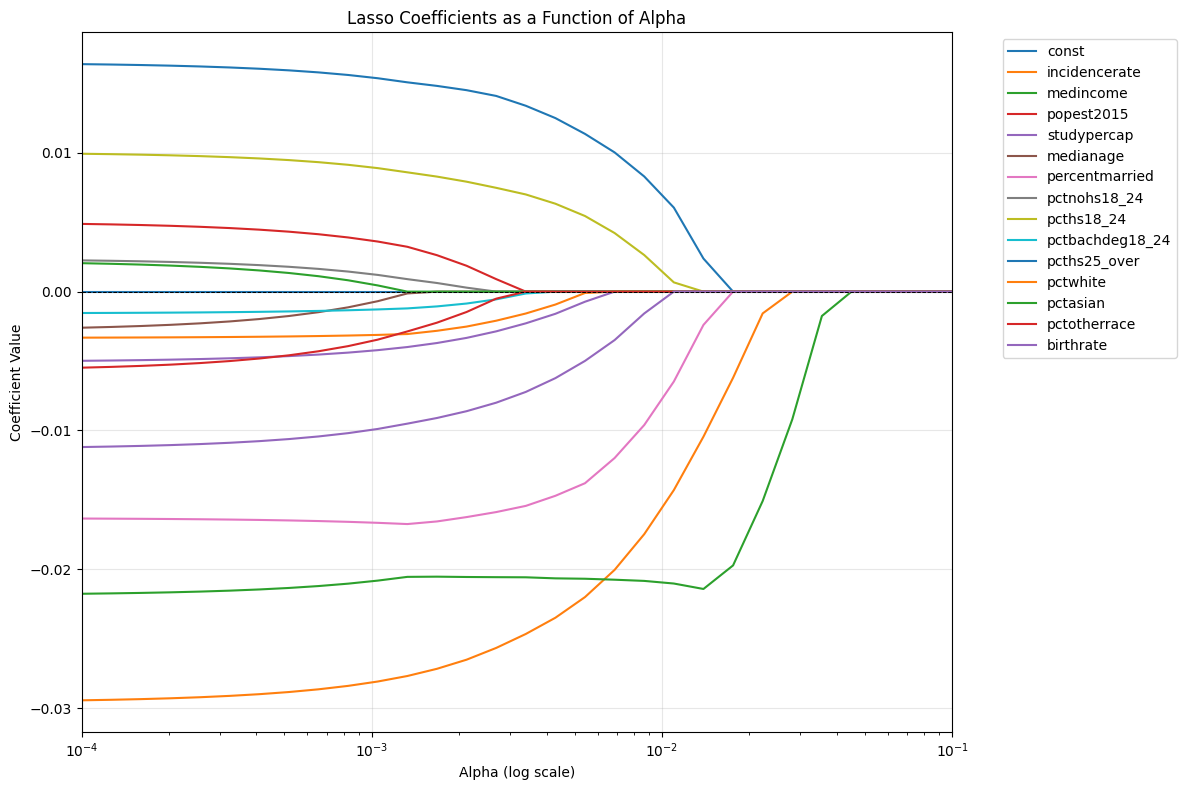

In [92]:
# Load and preprocess the dataset
# Assuming `cancer_df` is your dataset and `predictors` is your list of predictor variables
#predictors
y = cancer_df['case_fatality_rate']

# Split the data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(predictors, y, test_size=0.3, random_state=23)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)

# Standardize the predictors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Define alpha values and placeholders for results
alpha_values = np.logspace(-4, 1, 50)
validation_errors = []
remaining_coefficients = []
alpha_results = {}

# Train Lasso models for each alpha and store results
for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, random_state=23, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_val_pred = lasso.predict(X_val_scaled)
    
    # Calculate validation MSE
    val_mse = mean_squared_error(y_val, y_val_pred)
    validation_errors.append(val_mse)
    
    # Get remaining coefficients
    coef_nonzero = np.sum(lasso.coef_ != 0)
    remaining_coefficients.append(coef_nonzero)
    
    # Store results in dictionary
    alpha_results[alpha] = {
        "validation_mse": val_mse,
        "remaining_coefficients": coef_nonzero,
        "coefficients": {predictors.columns[i]: lasso.coef_[i] for i in range(len(predictors.columns)) if lasso.coef_[i] != 0}
    }

# Plot the coefficients for each predictor as a function of alpha
coefficients = []

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, random_state=23, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    coefficients.append(lasso.coef_)

coefficients = np.array(coefficients)

plt.figure(figsize=(12, 8))
for i, predictor in enumerate(predictors):
    plt.plot(alpha_values, coefficients[:, i], label=predictor)

plt.xscale('log')
plt.xlim(1e-4, 1e-1)  # Restrict x-axis range
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Value')
plt.title('Lasso Coefficients as a Function of Alpha')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Convert alpha results to a DataFrame for display
alpha_results_df = pd.DataFrame.from_dict(alpha_results, orient='index')

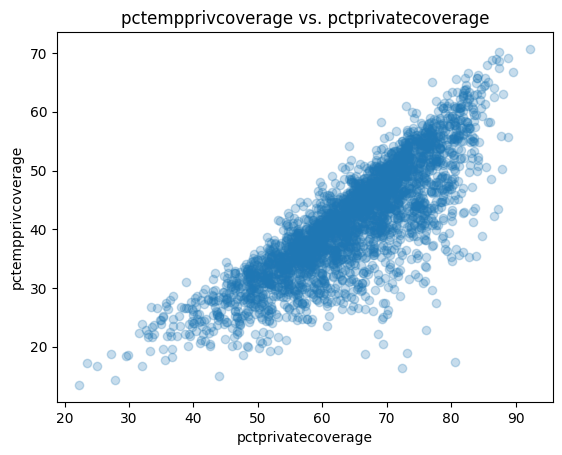

Index(['avganncount', 'avgdeathsperyear', 'target_deathrate', 'incidencerate',
       'medincome', 'popest2015', 'povertypercent', 'studypercap', 'binnedinc',
       'medianage', 'medianagemale', 'medianagefemale', 'geography',
       'percentmarried', 'pctnohs18_24', 'pcths18_24', 'pctbachdeg18_24',
       'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over',
       'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone',
       'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone',
       'pctwhite', 'pctblack', 'pctasian', 'pctotherrace',
       'pctmarriedhouseholds', 'birthrate', 'log_medincome',
       'avg_cases_per_100', 'avg_deaths_per_100', 'case_fatality_rate',
       'income_group', 'public_only_reliance', 'private_only_reliance',
       'state', 'case_fatality_groups_three', 'case_fatality_groups_five',
       'residuals'],
      dtype='object')

In [93]:
make_scatter("pctprivatecoverage", "pctempprivcoverage")
cancer_df.columns

In [94]:
# Select all predictors in your regression model
vif_data = pd.DataFrame()
vif_data["Feature"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
print(vif_data)

            Feature         VIF
0             const  242.357627
1     incidencerate    1.136797
2         medincome    2.277820
3        popest2015    1.357778
4       studypercap    1.026762
5         medianage    1.598754
6    percentmarried    2.824777
7      pctnohs18_24    1.382943
8        pcths18_24    1.449295
9   pctbachdeg18_24    1.732128
10     pcths25_over    1.939879
11         pctwhite    2.256050
12         pctasian    1.719821
13     pctotherrace    1.293858
14        birthrate    1.116374


incidencerate              1.000000
target_deathrate           0.449456
avg_deaths_per_100         0.227280
pctempprivcoverage         0.149815
pcths25_over               0.121766
pctblack                   0.113486
pctprivatecoverage         0.105179
pctunemployed16_over       0.099964
pctprivatecoveragealone    0.083872
studypercap                0.077271
avganncount                0.073534
avgdeathsperyear           0.062856
pctbachdeg18_24            0.046845
pctpubliccoverage          0.046155
pctpubliccoveragealone     0.040831
popest2015                 0.026884
pcths18_24                 0.022642
avg_cases_per_100          0.022476
povertypercent             0.009053
pctemployed16_over         0.004832
log_medincome              0.002050
medincome                 -0.001047
medianage                 -0.004764
pctasian                  -0.008232
medianagefemale           -0.009076
pctwhite                  -0.014475
medianagemale             -0.014712
pctbachdeg25_over         -0

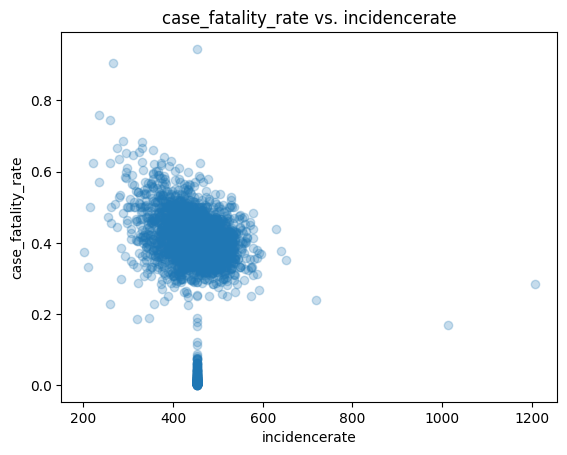

In [95]:
## 
import seaborn as sns

# Ensure all columns are numeric
cancer_df_numeric = cancer_df.select_dtypes(include=['number'])

# Calculate correlation matrix
correlation_matrix = cancer_df_numeric.corr()

# Correlation of incidence_rate with other features
print(correlation_matrix['incidencerate'].sort_values(ascending=False))

#cancer_df_numeric.columns

make_scatter("incidencerate", "case_fatality_rate")

In [96]:
##########################################3
## Ok, now lets try building a logistic regression model predicting whether or not a county is above the 
## median fatality rate based on certain features. 

# Create binary target variable (1 if above median, 0 otherwise)
median_rate = cancer_df['case_fatality_rate'].median()
cancer_df['high_fatality'] = (cancer_df['case_fatality_rate'] > median_rate).astype(int)

cancer_df.sample(10)
## median_rate = 0.405


avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
2085   570.000000               170             157.1     511.800000   
1328  1962.667684                42             183.5     453.549422   
1561   110.000000                46             169.5     438.300000   
2201   225.000000                88             183.5     487.100000   
647     40.000000                19             155.4     370.000000   
1793   161.000000                63             159.3     412.100000   
1235    40.000000                24             254.5     432.500000   
3046  1962.667684                48             213.6     453.549422   
173     94.000000                27             114.5     406.200000   
880   1037.000000               367             155.6     435.900000   

      medincome  popest2015  povertypercent  studypercap           binnedinc  \
2085      94334       99042             6.3    30.290180   (61494.5, 125635]   
1328      41527       16346            17.7  4098.862107  (40362.7, 42724.4]   
1561      38966       16005            20.6     0.000000  (37413.8, 40362.7]   
2201      44077       37927            17.4    26.366441    (42724.4, 45201]   
647       40667        9055            18.8   220.872446  (40362.7, 42724.4]   
1793      47227       40522            16.0     0.000000    (45201, 48021.6]   
1235      26204        7486            36.2     0.000000    [22640, 34218.1]   
3046      41193       37030            13.9     0.000000  (40362.7, 42724.4]   
173      108477       17785             4.2     0.000000   (61494.5, 125635]   
880       83698      245322             6.5   114.135707   (61494.5, 125635]   

      medianage  ...  avg_deaths_per_100  case_fatality_rate income_group  \
2085       42.8  ...            0.171644            0.298246         High   
1328       40.0  ...            0.256944            0.021399       Middle   
1561       48.2  ...            0.287410            0.418182          Low   
2201       39.2  ...            0.232025            0.391111       Middle   
647        33.7  ...            0.209829            0.475000          Low   
1793       35.6  ...            0.155471            0.391304       Middle   
1235       38.5  ...            0.320598            0.600000          Low   
3046       26.2  ...            0.129625            0.024457       Middle   
173        43.5  ...            0.151813            0.287234         High   
880        39.1  ...            0.149599            0.353905         High   

      public_only_reliance  private_only_reliance        state  \
2085                   Low                   High     New York   
1328                Middle                   High       Kansas   
1561                  High                    Low       Oregon   
2201                Middle                 Middle      Indiana   
647                    Low                 Middle     Nebraska   
1793                Middle                 Middle        Texas   
1235                  High                    Low  Mississippi   
3046                   Low                   High       Kansas   
173                    Low                   High   New Mexico   
880                    Low                   High     Maryland   

      case_fatality_groups_three  case_fatality_groups_five  residuals  \
2085                         Low                        Low  -0.018369   
1328                         Low                        Low  -0.353077   
1561                      Middle                     Middle   0.019493   
2201                      Middle                     Middle   0.010068   
647                         High                       High   0.115707   
1793                      Middle                     Middle  -0.041856   
1235                        High                       High   0.085997   
3046                         Low                        Low  -0.315959   
173                          Low                        Low   0.002219   
880              

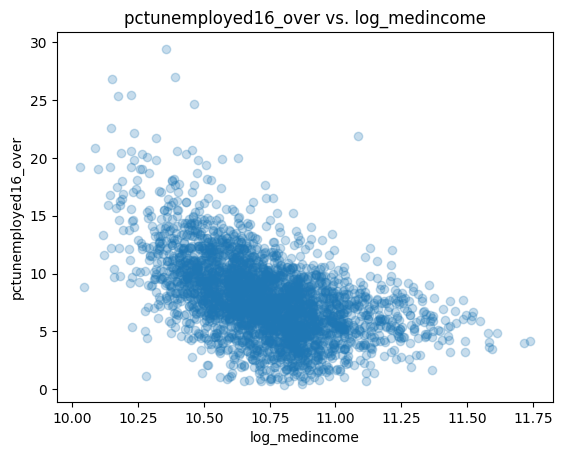

In [97]:
cancer_df.columns
make_scatter("log_medincome", "pctunemployed16_over")

In [98]:
# Spearman Correlation (monotonic relationship, better for nonlinear relationships)
spearman_corr = cancer_df['log_medincome'].corr(cancer_df['pctunemployed16_over'], method='spearman')
print(f"Spearman Correlation: {spearman_corr}")

## Seems to be ok that pctunemployed16 over is a predictor subject to hyperparamater tuning in Lasso Model building. 

Spearman Correlation: -0.5231162173507767


In [99]:
########################### TRY REPEATING LASSO WITH cancer_df_excluded_states and with log(median_income) instead. 

In [100]:
cancer_df_excluded_states['median_income_4'] = cancer_df_excluded_states['medincome']**4

cancer_df_excluded_states.sample(10)

C:\Users\zachw\AppData\Local\Temp\ipykernel_12672\2951537761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_df_excluded_states['median_income_4'] = cancer_df_excluded_states['medincome']**4


avganncount  avgdeathsperyear  target_deathrate  incidencerate  \
1547         59.0                39             226.4          354.7   
906          28.0                13             182.9          383.0   
497         130.0                53             172.5          471.0   
147         731.0               210             145.1          496.3   
1784        150.0                73             204.7          425.3   
2567        152.0                59             199.1          523.1   
1106         92.0                42             177.0          408.2   
2926        215.0                80             163.5          469.4   
2413        185.0                65             170.3          425.5   
1526         55.0                25             200.2          456.5   

      medincome  popest2015  povertypercent  studypercap           binnedinc  \
1547      32215       11183            23.1     0.000000    [22640, 34218.1]   
906       55493        8005            13.5   124.921924  (54545.6, 61494.5]   
497       53333       21103            11.6     0.000000  (51046.4, 54545.6]   
147      103876      125488             4.7    47.813337   (61494.5, 125635]   
1784      30516       31234            29.8     0.000000    [22640, 34218.1]   
2567      35368       24463            27.6    81.756121  (34218.1, 37413.8]   
1106      36377       10349            17.5     0.000000  (34218.1, 37413.8]   
2926      70127       39227             6.3  2141.382211   (61494.5, 125635]   
2413      41682       62467            17.2     0.000000  (40362.7, 42724.4]   
1526      52662        9870            12.5     0.000000  (51046.4, 54545.6]   

      medianage  ...  income_group  public_only_reliance  \
1547       44.8  ...           Low                  High   
906        33.0  ...          High                   Low   
497        40.6  ...          High                   Low   
147        45.0  ...          High                   Low   
1784       37.8  ...           Low                  High   
2567       40.3  ...           Low                  High   
1106       56.6  ...           Low                Middle   
2926       39.9  ...          High                   Low   
2413       27.6  ...        Middle                   Low   
1526       39.1  ...          High                Middle   

     private_only_reliance           state  case_fatality_groups_three  \
1547                   Low        Oklahoma                        High   
906                 Middle           Texas                        High   
497                   High    North Dakota                      Middle   
147                   High      New Jersey                         Low   
1784                   Low  South Carolina                        High   
2567                   Low        Kentucky                      Middle   
1106                   Low        Michigan                        High   
2926                  High        Illinois                         Low   
2413                   Low         Georgia                         Low   
1526                Middle        Oklahoma                        High   

      case_fatality_groups_five  medincome_related_avg  residuals  \
1547                       High              -1.614759   0.211250   
906                        High               0.070457   0.072348   
497                      Middle               0.887112   0.010389   
147                         Low               3.446322   0.015540   
1784                       High              -1.586698   0.032678   
2567                 Low Middle              -0.892105  -0.053776   
1106                       High              -0.338322   0.017094   
2926                 Low Middle               1.725430   0.016511   
2413                        Low               0.018176  -0.074897   
1526                Middle High               0.084382   0.055575   

      log_case_fatality_rate      median_income_4  
1547               -0.413976  10770417606487

In [101]:
## First need to drop all non-int non-float columns

cancer_df_es_quant = cancer_df_excluded_states.drop(columns=["binnedinc", "geography", "income_group", "public_only_reliance", "private_only_reliance", "state", "case_fatality_groups_three", "case_fatality_groups_five", "medincome_related_avg", "residuals", "log_case_fatality_rate"])

#correlations = cancer_df_excluded_states.corr()
#print(correlations['median_income_4'])

cancer_df_es_quant.info()

correlations = cancer_df_es_quant.corr()
print(correlations['median_income_4'])



<class 'pandas.core.frame.DataFrame'>
Index: 2841 entries, 0 to 3017
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avganncount              2841 non-null   float64
 1   avgdeathsperyear         2841 non-null   int64  
 2   target_deathrate         2841 non-null   float64
 3   incidencerate            2841 non-null   float64
 4   medincome                2841 non-null   int64  
 5   popest2015               2841 non-null   int64  
 6   povertypercent           2841 non-null   float64
 7   studypercap              2841 non-null   float64
 8   medianage                2841 non-null   float64
 9   medianagemale            2841 non-null   float64
 10  medianagefemale          2841 non-null   float64
 11  percentmarried           2841 non-null   float64
 12  pctnohs18_24             2841 non-null   float64
 13  pcths18_24               2841 non-null   float64
 14  pctbachdeg18_24          2841

In [102]:
## Ok I will still remove all variables correlated to medincome (r>=0.7) and medincome since I know they are exponentially related to medincome_4 e
## exponentially. 

predictors = cancer_df_es_quant.drop(columns=["case_fatality_rate"])
y = cancer_df_es_quant["case_fatality_rate"]

# Add a constant for the intercept in regression models.
predictors = sm.add_constant(predictors)

predictors.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2841 entries, 0 to 3017
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   const                    2841 non-null   float64
 1   avganncount              2841 non-null   float64
 2   avgdeathsperyear         2841 non-null   int64  
 3   target_deathrate         2841 non-null   float64
 4   incidencerate            2841 non-null   float64
 5   medincome                2841 non-null   int64  
 6   popest2015               2841 non-null   int64  
 7   povertypercent           2841 non-null   float64
 8   studypercap              2841 non-null   float64
 9   medianage                2841 non-null   float64
 10  medianagemale            2841 non-null   float64
 11  medianagefemale          2841 non-null   float64
 12  percentmarried           2841 non-null   float64
 13  pctnohs18_24             2841 non-null   float64
 14  pcths18_24               2841

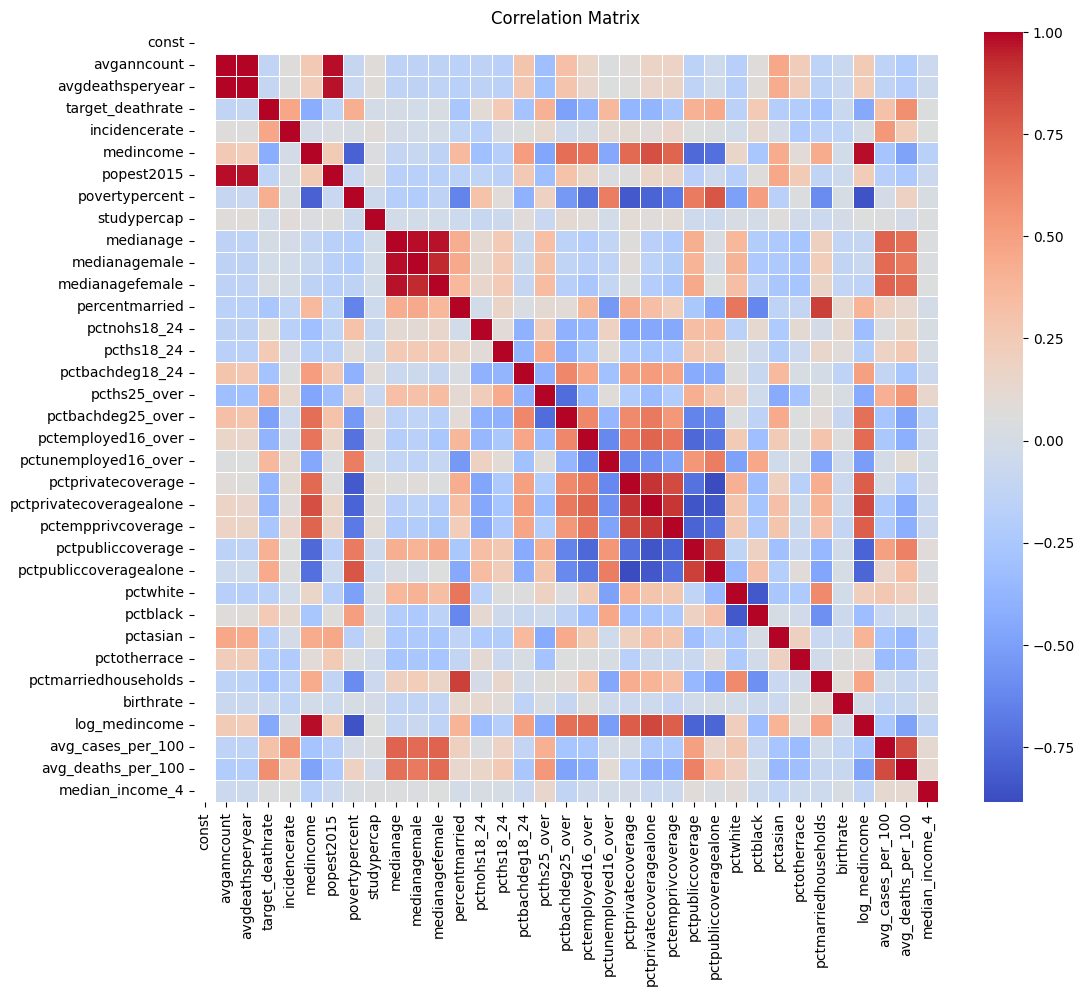

In [103]:
## Lets try to eliminate some features here (avoiding multicollinearity)
## Build a correlation matrix to see which features are correlated with eachother
corr_matrix = predictors.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [104]:
predictors.columns

Index(['const', 'avganncount', 'avgdeathsperyear', 'target_deathrate',
       'incidencerate', 'medincome', 'popest2015', 'povertypercent',
       'studypercap', 'medianage', 'medianagemale', 'medianagefemale',
       'percentmarried', 'pctnohs18_24', 'pcths18_24', 'pctbachdeg18_24',
       'pcths25_over', 'pctbachdeg25_over', 'pctemployed16_over',
       'pctunemployed16_over', 'pctprivatecoverage', 'pctprivatecoveragealone',
       'pctempprivcoverage', 'pctpubliccoverage', 'pctpubliccoveragealone',
       'pctwhite', 'pctblack', 'pctasian', 'pctotherrace',
       'pctmarriedhouseholds', 'birthrate', 'log_medincome',
       'avg_cases_per_100', 'avg_deaths_per_100', 'median_income_4'],
      dtype='object')

In [105]:
high_corr_pairs = corr_matrix.unstack().reset_index()
high_corr_pairs.columns = ["Variable 1", "Variable 2", "Correlation"]
high_corr_pairs = high_corr_pairs[
    (abs(high_corr_pairs["Correlation"]) > 0.7) & (high_corr_pairs["Variable 1"] != high_corr_pairs["Variable 2"])
]
print(high_corr_pairs)

              Variable 1          Variable 2  Correlation
37           avganncount    avgdeathsperyear     0.996993
41           avganncount          popest2015     0.981322
71      avgdeathsperyear         avganncount     0.996993
76      avgdeathsperyear          popest2015     0.977250
182            medincome      povertypercent    -0.791514
...                  ...                 ...          ...
1130   avg_cases_per_100       medianagemale     0.725021
1131   avg_cases_per_100     medianagefemale     0.754224
1153   avg_cases_per_100  avg_deaths_per_100     0.834953
1166  avg_deaths_per_100     medianagefemale     0.717081
1187  avg_deaths_per_100   avg_cases_per_100     0.834953

[92 rows x 3 columns]


In [106]:
## Drop all predictors correlated (r>=0.7) with medincome, then, drop medincome, leaving medincome_4 in model
predictors = predictors.drop(columns=["avganncount", "avgdeathsperyear", "avg_cases_per_100", "avg_deaths_per_100", "log_medincome", "pctmarriedhouseholds", "pctprivatecoverage", "pctbachdeg25_over", "povertypercent", "pctprivatecoveragealone", "pctempprivcoverage", "pctpubliccoverage", "pctpubliccoveragealone", "pctblack", "medianagemale", "medianagefemale", "medincome"])
predictors.columns

Index(['const', 'target_deathrate', 'incidencerate', 'popest2015',
       'studypercap', 'medianage', 'percentmarried', 'pctnohs18_24',
       'pcths18_24', 'pctbachdeg18_24', 'pcths25_over', 'pctemployed16_over',
       'pctunemployed16_over', 'pctwhite', 'pctasian', 'pctotherrace',
       'birthrate', 'median_income_4'],
      dtype='object')

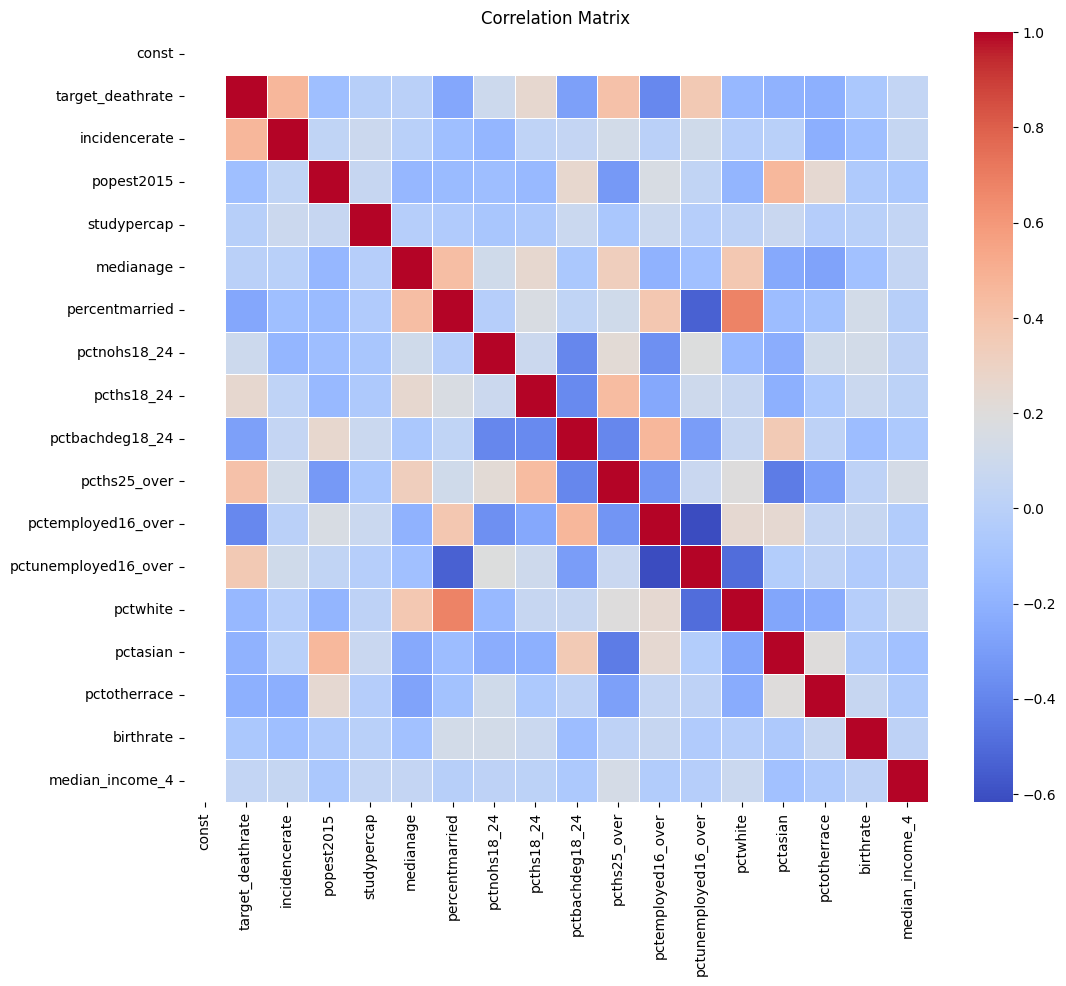

In [107]:
## Lets try to eliminate some features here (avoiding multicollinearity)
## Build a correlation matrix to see which features are correlated with eachother
corr_matrix = predictors.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [108]:
high_corr_pairs = corr_matrix.unstack().reset_index()
high_corr_pairs.columns = ["Variable 1", "Variable 2", "Correlation"]
high_corr_pairs = high_corr_pairs[
    (abs(high_corr_pairs["Correlation"]) > 0.7) & (high_corr_pairs["Variable 1"] != high_corr_pairs["Variable 2"])
]
print(high_corr_pairs)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []


In [109]:
## 70% of predictor data will go to X_train, 70% of case_fatality will go to y_train, the rest will go to X_temp and y_temp, 
## which will be further split up into validation set (used for tuning hyperparameters, like alpha (penalty term in Lasso)), 
## and testing set, which is used to evaluate how well the model generalizes to unseen data

## Note that this is using median_income ^^4 polynomial transformation
X_train, X_temp, y_train, y_temp = train_test_split(predictors, y, test_size=0.3, random_state=23)

## 15% of overall data to validation set, 15% of overall data to test set
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=23)

In [110]:
## Now, we need to standardize our feature variables to ensure that lasso penaltizes each feature fairly
## Lasso penalizes coefficients based on their magnitude, so features need to be on the same scale to ensure fair penalization. 
## Without scaling, a variable with a large range (e.g., income) might dominate the penalty term.

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [111]:
alpha_values = np.logspace(-4, 1, 50)
validation_errors = []

for alpha in alpha_values:
    lasso = Lasso(alpha=alpha, random_state=23, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    y_val_pred = lasso.predict(X_val_scaled)
    val_mse = mean_squared_error(y_val, y_val_pred)
    validation_errors.append(val_mse)

#alpha_values
len(validation_errors)

50

In [112]:
#best_alpha = alpha_values[np.argmin(validation_errors)]

## Let's try the midpoint alpha value first to balance a small mse without reducing our coeffecients too much
midpoint_index = int((len(validation_errors) / 2))
midpoint_alpha = alpha_values[midpoint_index]
midpoint_alpha

## Now, lets try using the best alpha to see what coeffecients remain
best_alpha = alpha_values[np.argmin(validation_errors)]
best_alpha

test_alpha = alpha_values[midpoint_index - 5]

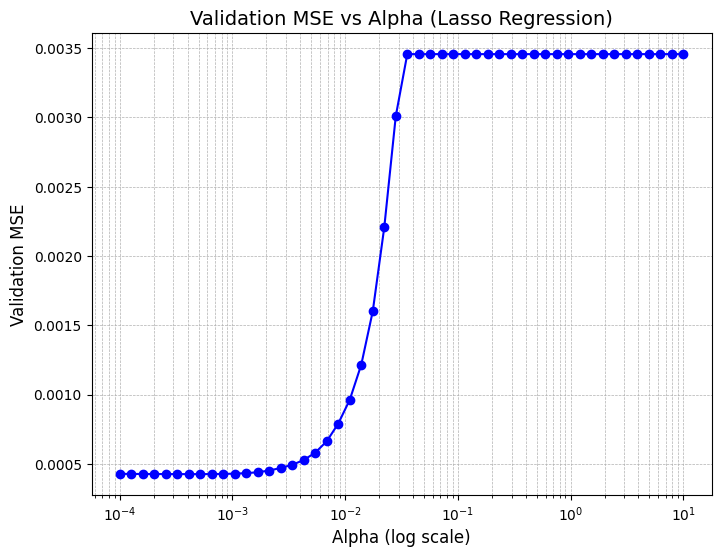

In [113]:
# Assuming alpha_values and validation_errors are already defined
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(alpha_values, validation_errors, marker='o', linestyle='-', color='b')  # Create the line plot
plt.xscale('log')  # Set the x-axis to a logarithmic scale for alpha
plt.xlabel('Alpha (log scale)', fontsize=12)  # Label for x-axis
plt.ylabel('Validation MSE', fontsize=12)  # Label for y-axis
plt.title('Validation MSE vs Alpha (Lasso Regression)', fontsize=14)  # Title of the plot
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid for better readability
plt.show()

In [114]:
## Alpha parameter decides what alpha we are using
lasso_best = Lasso(alpha=test_alpha, random_state=23, max_iter=10000)
lasso_best.fit(X_train_scaled, y_train)

Lasso(alpha=np.float64(0.010985411419875584), max_iter=10000, random_state=23)

In [115]:
y_test_pred = lasso_best.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, y_test_pred)
test_mse

0.0013138593623158396

In [116]:
## Now we will see which coeffecients are retained
coefficients = lasso_best.coef_

feature_names = X_train.columns  # Replace with the names of your features
retained_features = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

retained_features = retained_features[retained_features["Coefficient"] != 0]
print(retained_features)

retained_features = retained_features.sort_values(by="Coefficient", ascending=True)
retained_features

             Feature  Coefficient
1   target_deathrate     0.038062
2      incidencerate    -0.029811
10      pcths25_over     0.000523


Feature  Coefficient
2      incidencerate    -0.029811
10      pcths25_over     0.000523
1   target_deathrate     0.038062